# Group 1: Capstone Project - Forecasting State-Wise Crop Yield in India

## Objective :

Build a regression model to forecast the future cropyield for major crops like rice, wheat, sugarcane, andmaize across Indian states. 
Using historical data on crop yield, area, and production from the Crop Yield in Indian States dataset, the model will predict future yields to inform agricultural planning and policy decisions. The system will be trained using models such as Linear Regression, XGBoost, and LSTM.

### Key Points:

✔ Supports agricultural planning

✔ Helps policymakers allocate resources

✔ Identifies yield trends and variability

✔ Improves food security and farmer planning



## Datasets used here :

https://www.kaggle.com/datasets/anshumish/crop-yield-data-with-soil-and-weather-dataset/data

1. crop_yield.csv
2. state_soil_data.csv
3. state_weather_data_1997_2020.csv

### ➨ Dataset 1 → crop_yield.csv

| **Attribute**       | **Meaning**                                                       | **Why It Matters**                                                                 |
| ------------------- | ----------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **Crop**            | Name of the crop (e.g., Rice, Wheat, Maize).                      | Different crops respond differently to soil, climate, and inputs.                  |
| **Crop_Year**       | Year of cultivation (1997–2020).                                  | Links crop records to yearly weather data; used for trend analysis.                |
| **Season**          | Season of cropping (Kharif = Monsoon, Rabi = Winter, Whole Year). | Determines which part of the year’s climate matters.                               |
| **State**           | Indian state where the crop was cultivated.                       | Geographic key for merging soil & weather data.                                    |
| **Area**            | Total cultivated area under that crop (likely in hectares).       | Needed to calculate per-hectare measures; larger areas may imply commercial scale. |
| **Production**      | Total crop output (likely in tonnes).                             | Combined with Area → Yield; checks consistency of data.                            |
| **Annual_Rainfall** | Rainfall value reported with crop data (mm, but may be average).  | Can be compared with weather rainfall; sometimes represents long-term averages.    |
| **Fertilizer**      | Quantity of fertilizer applied (kg or tonnes).                    | Reflects input intensity; best used per hectare.                                   |
| **Pesticide**       | Quantity of pesticide applied.                                    | Proxy for crop protection intensity.                                               |
| **Yield**           | Yield per hectare (likely tonnes/ha).                             | Primary agricultural performance indicator (target variable in modeling).          |


### ➨ Dataset 2 → state_soil_data.csv

| **Attribute**      | **Meaning**                    | **Why It Matters**                                                                 |
| ------------------ | ------------------------------ | ---------------------------------------------------------------------------------- |
| **state**          | Name of the state.             | Join key to crop & weather data.                                                   |
| **N (Nitrogen)**   | Soil nitrogen content/index.   | Crucial macronutrient; affects vegetative growth and yield response to fertilizer. |
| **P (Phosphorus)** | Soil phosphorus content/index. | Important for root growth, flowering, and seed formation.                          |
| **K (Potassium)**  | Soil potassium content/index.  | Enhances stress tolerance, disease resistance, and productivity.                   |
| **pH**             | Soil pH (acidity/alkalinity).  | Controls nutrient availability; extreme values harm crop performance.              |



### ➨ Dataset 3 → state_weather_data_1997_2020.csv

| **Attribute**            | **Meaning**                       | **Why It Matters**                                       |
| ------------------------ | --------------------------------- | -------------------------------------------------------- |
| **state**                | Name of the state.                | Join key for merging with crop data.                     |
| **year**                 | Year of record (1997–2020).       | Temporal key to align with crop yields.                  |
| **avg_temp_c**           | Average annual temperature (°C).  | Captures heat stress or favorable temperature ranges.    |
| **total_rainfall_mm**    | Total rainfall in that year (mm). | Primary water availability measure; critical for yield.  |
| **avg_humidity_percent** | Average annual humidity (%).      | Influences evapotranspiration and pest/disease pressure. |

In [1832]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Plotly (interactive plots)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn preprocessing, pipelines, and model selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

# Scikit-learn models
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Scikit-learn metrics and inspection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Other utilities
import joblib
import pickle
import streamlit as st
from scipy.stats import randint, uniform
import optuna


import warnings
warnings.filterwarnings("ignore")

## Understanding and Preprocessing the data 

In [1835]:
# Load all three datasets
crop_yield = pd.read_csv("crop_yield.csv")
state_soil = pd.read_csv("state_soil_data.csv")
state_weather = pd.read_csv("state_weather_data_1997_2020.csv")

# Inspect first few rows
crop_yield_head = crop_yield.head(10)
state_soil_head = state_soil.head(10)
state_weather_head = state_weather.head(10)

In [1837]:
print("\nCrop Yeild Sample Dataset : \n")
crop_yield_head


Crop Yeild Sample Dataset : 



,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909
5,Dry chillies,1997,Whole Year,Assam,13587.0,9073,2051.4,1293074.79,4211.97,0.643636
6,Gram,1997,Rabi,Assam,2979.0,1507,2051.4,283511.43,923.49,0.465455
7,Jute,1997,Kharif,Assam,94520.0,904095,2051.4,8995468.40,29301.20,9.919565
8,Linseed,1997,Rabi,Assam,10098.0,5158,2051.4,961026.66,3130.38,0.461364
9,Maize,1997,Kharif,Assam,19216.0,14721,2051.4,1828786.72,5956.96,0.615652


In [1839]:
print("\nState Soil Sample Dataset : \n")
state_soil_head


State Soil Sample Dataset : 



,state,N,P,K,pH
0,Andhra Pradesh,78,45,22,6.8
1,Arunachal Pradesh,55,15,35,5.5
2,Assam,60,18,38,5.8
3,Bihar,85,30,25,7.2
4,Chhattisgarh,70,35,20,6.5
5,Delhi,90,40,30,7.5
6,Goa,65,25,45,6.2
7,Gujarat,75,38,28,7.8
8,Haryana,130,48,35,7.9
9,Himachal Pradesh,60,20,40,6.0


In [1841]:
print("\nState Weather Sample Dataset : \n")
state_weather_head


State Weather Sample Dataset : 



,state,year,avg_temp_c,total_rainfall_mm,avg_humidity_percent
0,Andhra Pradesh,1997,28.21,1191.08,69.56
1,Andhra Pradesh,1998,28.21,1100.41,71.95
2,Andhra Pradesh,1999,28.03,603.67,66.91
3,Andhra Pradesh,2000,27.74,1070.25,70.73
4,Andhra Pradesh,2001,28.08,910.13,68.69
5,Andhra Pradesh,2002,28.54,768.22,66.52
6,Andhra Pradesh,2003,28.31,857.23,68.83
7,Andhra Pradesh,2004,27.72,759.10,69.79
8,Andhra Pradesh,2005,27.95,1192.26,71.10
9,Andhra Pradesh,2006,27.65,1343.62,71.34


In [1843]:
# Unique States from all three datasets
crop_yield_states = set(crop_yield['State'].unique())
state_soil_states = set(state_soil['state'].unique())
state_weather_states = set(state_weather['state'].unique())

print("\n------------- Unique States from Crop Yeil Dataset : ------------- \n", crop_yield_states)
print("\n------------- Unique States from State Soil Dataset : ------------- \n", state_soil_states)
print("\n------------- Unique States from State Weather Dataset : ------------- \n", state_weather_states)


------------- Unique States from Crop Yeil Dataset : ------------- 
 {'Bihar', 'Gujarat', 'Andhra Pradesh', 'Goa', 'Maharashtra', 'Puducherry', 'Sikkim', 'Manipur', 'Tamil Nadu', 'Uttar Pradesh', 'Tripura', 'Uttarakhand', 'Meghalaya', 'Odisha', 'Punjab', 'Arunachal Pradesh', 'Delhi', 'Telangana', 'Himachal Pradesh', 'Jammu and Kashmir', 'West Bengal', 'Mizoram', 'Jharkhand', 'Madhya Pradesh', 'Haryana', 'Chhattisgarh', 'Kerala', 'Nagaland', 'Assam', 'Karnataka'}

------------- Unique States from State Soil Dataset : ------------- 
 {'Bihar', 'Gujarat', 'Andhra Pradesh', 'Goa', 'Maharashtra', 'Puducherry', 'Sikkim', 'Manipur', 'Tamil Nadu', 'Uttar Pradesh', 'Tripura', 'Uttarakhand', 'Meghalaya', 'Odisha', 'Punjab', 'Arunachal Pradesh', 'Delhi', 'Telangana', 'Himachal Pradesh', 'Jammu and Kashmir', 'West Bengal', 'Mizoram', 'Jharkhand', 'Madhya Pradesh', 'Chhattisgarh', 'Haryana', 'Kerala', 'Nagaland', 'Assam', 'Karnataka'}

------------- Unique States from State Weather Dataset : -----

In [1845]:
# Common States (present in all three datasets)

common_states = crop_yield_states & state_soil_states & state_weather_states
print("\n---- Common States across all three datasets ----\n", common_states)


---- Common States across all three datasets ----
 {'Bihar', 'Gujarat', 'Andhra Pradesh', 'Goa', 'Maharashtra', 'Puducherry', 'Sikkim', 'Manipur', 'Tamil Nadu', 'Uttar Pradesh', 'Tripura', 'Uttarakhand', 'Meghalaya', 'Odisha', 'Punjab', 'Arunachal Pradesh', 'Delhi', 'Telangana', 'Himachal Pradesh', 'Jammu and Kashmir', 'West Bengal', 'Mizoram', 'Jharkhand', 'Madhya Pradesh', 'Chhattisgarh', 'Haryana', 'Kerala', 'Nagaland', 'Assam', 'Karnataka'}


In [1847]:
# Unique States in each dataset (present in that dataset but not in the others)

unique_crop_states = crop_yield_states - (state_soil_states | state_weather_states)
unique_soil_states = state_soil_states - (crop_yield_states | state_weather_states)
unique_weather_states = state_weather_states - (crop_yield_states | state_soil_states)

print("\n---- States only in Crop Yield dataset ----\n", unique_crop_states)
print("\n---- States only in State Soil dataset ----\n", unique_soil_states)
print("\n---- States only in State Weather dataset ----\n", unique_weather_states)


---- States only in Crop Yield dataset ----
 set()

---- States only in State Soil dataset ----
 set()

---- States only in State Weather dataset ----
 set()


### ➨ Interpreting the above results

1. crop_yield_states has 30 states/UTs.
2. state_soil_states has the same set (30 states/UTs).
3. state_weather_states also has the same set (30 states/UTs).

That means:

1. Common states (all three): all 30 states/UTs.
2. Unique states in each dataset: none — empty sets.


### ➨ Logic Behind Combining These Three Datasets

**The final dataset unit of observation = Crop × State × Year × Season**
1. Base dataset: crop_yield.csv → contains crop-level data per state-year-season.
2. Join with weather: using (State, Year) because weather is annual and state-level.
3. Join with soil: using State only, since soil properties are static (don’t change every year in your dataset).


### ➨ Attribute-level logic in the Final Dataset
| **Final Attribute**      | **Source**                                | **How It’s Combined**                                    | **Reasoning**                                                                      |
| ------------------------ | ----------------------------------------- | -------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **crop**                 | `crop_yield.Crop`                         | Taken directly.                                          | Crop name is unique to the crop yield dataset — not in soil/weather.               |
| **year**                 | `crop_yield.Crop_Year`                    | Align with `weather.year`.                               | Crop yield is for a specific year; matched with state’s weather for the same year. |
| **season**               | `crop_yield.Season`                       | Taken directly.                                          | Only available in crop data — defines growing period.                              |
| **state**                | `crop_yield.State`                        | Join key with soil + weather.                            | All three datasets share state-level info.                                         |
| **area**                 | `crop_yield.Area`                         | Taken directly.                                          | Crop-specific land area (hectares).                                                |
| **production**           | `crop_yield.Production`                   | Taken directly.                                          | Crop-specific production (tonnes).                                                 |
| **fertilizer**           | `crop_yield.Fertilizer`                   | Taken directly.                                          | Represents total fertilizer use in that crop’s area.                               |
| **pesticide**            | `crop_yield.Pesticide`                    | Taken directly.                                          | Crop-specific pesticide usage.                                                     |
| **yield**                | `crop_yield.Yield`                        | Taken directly (but cross-check with `Production/Area`). | This is the target variable of interest (output).                                  |
| **avg_temp_c**           | `state_weather_data.avg_temp_c`           | Join on `(State, Year)`.                                 | State’s yearly average temperature affects yield.                                  |
| **total_rainfall_mm**    | `state_weather_data.total_rainfall_mm`    | Join on `(State, Year)`.                                 | State’s yearly rainfall drives water availability.                                 |
| **avg_humidity_percent** | `state_weather_data.avg_humidity_percent` | Join on `(State, Year)`.                                 | Humidity affects evapotranspiration and disease risk.                              |
| **N**                    | `state_soil_data.N`                       | Join on `State`.                                         | Soil nutrient baseline, doesn’t change year-to-year.                               |
| **P**                    | `state_soil_data.P`                       | Join on `State`.                                         | Same reasoning as N.                                                               |
| **K**                    | `state_soil_data.K`                       | Join on `State`.                                         | Same reasoning as N.                                                               |
| **pH**                   | `state_soil_data.pH`                      | Join on `State`.                                         | Soil acidity/alkalinity constraint; constant for state.                            |



<img src="Flow_Chart_Data_Merge.png" width="800"/>

In [1850]:
# Initial column names 
print("\n------------------------- Initial column names -------------------------\n")
print("\n1. crop_yield.columns : \n", crop_yield.columns)
print("\n2. state_weather.columns : \n", state_weather.columns)
print("\n3. state_soil.columns : \n", state_soil.columns)



# Standardize column names
crop_yield.columns = crop_yield.columns.str.strip().str.lower()
state_weather.columns = state_weather.columns.str.strip().str.lower()
state_soil.columns = state_soil.columns.str.strip().str.lower()

# After Standardizing column names 
print("\n------------------------- After Standardizing column names -------------------------\n")
print("\n1. crop_yield.columns : \n", crop_yield.columns)
print("\n2. state_weather.columns : \n", state_weather.columns)
print("\n3. state_soil.columns : \n", state_soil.columns)


------------------------- Initial column names -------------------------


1. crop_yield.columns : 
 Index(['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Production',
       'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield'],
      dtype='object')

2. state_weather.columns : 
 Index(['state', 'year', 'avg_temp_c', 'total_rainfall_mm',
       'avg_humidity_percent'],
      dtype='object')

3. state_soil.columns : 
 Index(['state', 'N', 'P', 'K', 'pH'], dtype='object')

------------------------- After Standardizing column names -------------------------


1. crop_yield.columns : 
 Index(['crop', 'crop_year', 'season', 'state', 'area', 'production',
       'annual_rainfall', 'fertilizer', 'pesticide', 'yield'],
      dtype='object')

2. state_weather.columns : 
 Index(['state', 'year', 'avg_temp_c', 'total_rainfall_mm',
       'avg_humidity_percent'],
      dtype='object')

3. state_soil.columns : 
 Index(['state', 'n', 'p', 'k', 'ph'], dtype='object')


In [1852]:
# Rename crop_year -> year
if "crop_year" in crop_yield.columns:
    crop_yield.rename(columns={"crop_year": "year"}, inplace=True)

print("\ncrop_yield.columns : \n", crop_yield.columns)    


crop_yield.columns : 
 Index(['crop', 'year', 'season', 'state', 'area', 'production',
       'annual_rainfall', 'fertilizer', 'pesticide', 'yield'],
      dtype='object')


In [1854]:
# Merge crop_yield + state_weather on (state, year)
crop_yield_state_weather_merge = pd.merge( crop_yield, state_weather, on=["state", "year"], how="left" )

print("\nColumns after merging crop_yeild and state_weather : \n")
crop_yield_state_weather_merge.columns


Columns after merging crop_yeild and state_weather : 



Index(['crop', 'year', 'season', 'state', 'area', 'production',
       'annual_rainfall', 'fertilizer', 'pesticide', 'yield', 'avg_temp_c',
       'total_rainfall_mm', 'avg_humidity_percent'],
      dtype='object')

In [1856]:
print("\nSample data rows after merging crop_yeild and state_weather : \n")
crop_yield_state_weather_merge.sample(n=20)


Sample data rows after merging crop_yeild and state_weather : 



,crop,year,season,state,area,production,annual_rainfall,fertilizer,pesticide,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent
7202,Coriander,2000,Whole Year,Madhya Pradesh,94705.0,27475,723.3,9297189.85,24623.30,0.307674,25.33,867.75,42.57
18740,Rice,2009,Kharif,Sikkim,12270.0,20930,2176.6,1911911.40,2085.90,1.595000,7.76,924.82,70.34
19067,Turmeric,2002,Whole Year,Arunachal Pradesh,514.0,2020,2832.8,48660.38,128.50,4.459091,22.38,1782.25,70.83
17736,other oilseeds,2005,Kharif,Jammu and Kashmir,20.0,9,1721.8,2398.40,4.20,0.415000,8.63,575.81,53.20
1315,Rice,2003,Kharif,Goa,35471.0,115996,3011.6,3510919.58,8513.04,3.270000,27.88,1413.96,71.80
6611,Urad,1998,Rabi,Tripura,500.0,230,2472.9,49400.00,145.00,0.457500,25.37,1919.99,73.93
11972,Other Rabi pulses,2010,Rabi,West Bengal,255.0,112,1096.0,42358.05,61.20,0.446667,26.24,1356.15,72.90
17894,Sesamum,2009,Kharif,Jammu and Kashmir,4624.0,2031,751.7,720511.68,786.08,0.443333,9.04,557.76,51.57
5999,Ragi,2019,Rabi,Karnataka,41861.0,59315,1422.3,7190045.36,15488.57,1.409259,24.57,818.07,65.92
17814,Coriander,2007,Rabi,Jammu and Kashmir,9.0,1,1042.2,1200.60,1.44,0.125000,9.55,553.51,51.34


In [1858]:
# Merge crop_yield_state_weather_merge with state_soil data (only on state)
crop_yield_state_weather_state_soil_merge = pd.merge(crop_yield_state_weather_merge, state_soil, on="state", how="left")

print("\nColumns after merging crop_yeild, state_weather and state_soil : \n")
crop_yield_state_weather_state_soil_merge.columns


Columns after merging crop_yeild, state_weather and state_soil : 



Index(['crop', 'year', 'season', 'state', 'area', 'production',
       'annual_rainfall', 'fertilizer', 'pesticide', 'yield', 'avg_temp_c',
       'total_rainfall_mm', 'avg_humidity_percent', 'n', 'p', 'k', 'ph'],
      dtype='object')

In [1860]:
print("\nSample data rows after merging crop_yeild, state_weather and state_soil : \n")
crop_yield_state_weather_state_soil_merge.sample(n=20)


Sample data rows after merging crop_yeild, state_weather and state_soil : 



,crop,year,season,state,area,production,annual_rainfall,fertilizer,pesticide,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,n,p,k,ph
18113,Other Cereals,2014,Kharif,Jammu and Kashmir,519.0,213,1278.4,7.834824e+04,171.27,0.517143,8.70,817.82,57.75,70,25,42,6.7
18718,Other Kharif pulses,2007,Kharif,Sikkim,4610.0,3810,2003.4,6.149740e+05,737.60,0.647500,7.57,914.37,72.94,50,20,30,5.5
11763,Ragi,2010,Kharif,Nagaland,300.0,280,1771.8,4.983300e+04,72.00,0.955714,18.12,1662.35,76.28,56,16,36,5.8
10480,Horse-gram,2007,Kharif,Uttarakhand,9001.0,7005,1924.3,1.200733e+06,1440.16,0.749091,18.07,1427.79,54.33,80,24,38,6.4
16587,Tobacco,2018,Whole Year,Uttarakhand,1.0,2,1373.0,1.622000e+02,0.35,2.000000,17.97,1510.52,57.73,80,24,38,6.4
2994,Wheat,2009,Rabi,Karnataka,283427.0,263877,1321.0,4.416360e+07,48182.59,0.919286,23.50,858.32,69.07,72,42,25,6.9
17885,Other Cereals,2009,Rabi,Jammu and Kashmir,112.0,78,751.7,1.745184e+04,19.04,0.700000,9.04,557.76,51.57,70,25,42,6.7
15770,Sesamum,2017,Kharif,Nagaland,3660.0,2230,1722.1,5.762304e+05,1390.80,0.607273,18.47,1957.87,78.51,56,16,36,5.8
11313,Other Cereals,2009,Kharif,Uttarakhand,3767.0,1460,847.8,5.869739e+05,640.39,0.435000,18.52,965.68,49.98,80,24,38,6.4
1691,Moong(Green Gram),2005,Kharif,Andhra Pradesh,251959.0,122697,1075.5,3.021492e+07,52911.39,0.582273,27.95,1192.26,71.10,78,45,22,6.8


In [1862]:
# Select final required columns (dropping off annual_rainfall, since we have total_rainfall_mm column)
crop_yield_state_weather_state_soil_merge = crop_yield_state_weather_state_soil_merge[
    ['crop', 'year', 'season', 'state', 'area', 'production', 'fertilizer', 'pesticide',
     'yield', 'avg_temp_c', 'total_rainfall_mm', 'avg_humidity_percent', 'n', 'p', 'k', 'ph']
]

# Save the final dataset to csv file 
crop_yield_state_weather_state_soil_merge.to_csv("final_merged_statewise_crop_yeild_dataset.csv", index=False)

print("\nFinal merged dataset created with shape :\n", crop_yield_state_weather_state_soil_merge.shape)


Final merged dataset created with shape :
 (19689, 16)


In [1864]:
df = pd.read_csv("final_merged_statewise_crop_yeild_dataset.csv")

In [1866]:
df.columns.tolist()

['crop',
 'year',
 'season',
 'state',
 'area',
 'production',
 'fertilizer',
 'pesticide',
 'yield',
 'avg_temp_c',
 'total_rainfall_mm',
 'avg_humidity_percent',
 'n',
 'p',
 'k',
 'ph']

In [1868]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crop                  19689 non-null  object 
 1   year                  19689 non-null  int64  
 2   season                19689 non-null  object 
 3   state                 19689 non-null  object 
 4   area                  19689 non-null  float64
 5   production            19689 non-null  int64  
 6   fertilizer            19689 non-null  float64
 7   pesticide             19689 non-null  float64
 8   yield                 19689 non-null  float64
 9   avg_temp_c            19689 non-null  float64
 10  total_rainfall_mm     19689 non-null  float64
 11  avg_humidity_percent  19689 non-null  float64
 12  n                     19689 non-null  int64  
 13  p                     19689 non-null  int64  
 14  k                     19689 non-null  int64  
 15  ph                 

In [1870]:
# Change year column to object (categorical)
df['year'] = df['year'].astype(object)   # or .astype('object')

In [1872]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crop                  19689 non-null  object 
 1   year                  19689 non-null  object 
 2   season                19689 non-null  object 
 3   state                 19689 non-null  object 
 4   area                  19689 non-null  float64
 5   production            19689 non-null  int64  
 6   fertilizer            19689 non-null  float64
 7   pesticide             19689 non-null  float64
 8   yield                 19689 non-null  float64
 9   avg_temp_c            19689 non-null  float64
 10  total_rainfall_mm     19689 non-null  float64
 11  avg_humidity_percent  19689 non-null  float64
 12  n                     19689 non-null  int64  
 13  p                     19689 non-null  int64  
 14  k                     19689 non-null  int64  
 15  ph                 

In [1874]:
df.describe()

,area,production,fertilizer,pesticide,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,n,p,k,ph
count,1.968900e+04,1.968900e+04,1.968900e+04,1.968900e+04,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000,19689.000000
mean,1.799266e+05,1.643594e+07,2.410331e+07,4.884835e+04,79.954009,24.008025,1337.999356,64.676018,76.626847,33.499264,32.234547,6.640292
std,7.328287e+05,2.630568e+08,9.494600e+07,2.132874e+05,878.306193,4.408018,637.585197,11.474130,20.060556,11.556686,7.915514,0.690622
min,5.000000e-01,0.000000e+00,5.417000e+01,9.000000e-02,0.000000,6.260000,249.240000,34.470000,50.000000,15.000000,20.000000,5.500000
25%,1.390000e+03,1.393000e+03,1.880146e+05,3.567000e+02,0.600000,22.910000,894.160000,54.620000,65.000000,24.000000,25.000000,6.000000
50%,9.317000e+03,1.380400e+04,1.234957e+06,2.421900e+03,1.030000,25.560000,1172.020000,68.110000,72.000000,38.000000,33.000000,6.600000
75%,7.511200e+04,1.227180e+05,1.000385e+07,2.004170e+04,2.388889,26.810000,1613.400000,73.730000,80.000000,43.000000,38.000000,7.100000
max,5.080810e+07,6.326000e+09,4.835407e+09,1.575051e+07,21105.000000,28.630000,5244.360000,86.060000,150.000000,55.000000,50.000000,8.000000


In [1876]:
df.head(10)

,crop,year,season,state,area,production,fertilizer,pesticide,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,n,p,k,ph
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,7024878.38,22882.34,0.796087,22.41,1468.92,70.71,60,18,38,5.8
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,631643.29,2057.47,0.710435,22.41,1468.92,70.71,60,18,38,5.8
2,Castor seed,1997,Kharif,Assam,796.0,22,75755.32,246.76,0.238333,22.41,1468.92,70.71,60,18,38,5.8
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,1870661.52,6093.36,5238.051739,22.41,1468.92,70.71,60,18,38,5.8
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,165500.63,539.09,0.420909,22.41,1468.92,70.71,60,18,38,5.8
5,Dry chillies,1997,Whole Year,Assam,13587.0,9073,1293074.79,4211.97,0.643636,22.41,1468.92,70.71,60,18,38,5.8
6,Gram,1997,Rabi,Assam,2979.0,1507,283511.43,923.49,0.465455,22.41,1468.92,70.71,60,18,38,5.8
7,Jute,1997,Kharif,Assam,94520.0,904095,8995468.40,29301.20,9.919565,22.41,1468.92,70.71,60,18,38,5.8
8,Linseed,1997,Rabi,Assam,10098.0,5158,961026.66,3130.38,0.461364,22.41,1468.92,70.71,60,18,38,5.8
9,Maize,1997,Kharif,Assam,19216.0,14721,1828786.72,5956.96,0.615652,22.41,1468.92,70.71,60,18,38,5.8


In [1878]:
# Check missing values
df.isnull().sum()

crop                    0
year                    0
season                  0
state                   0
area                    0
production              0
fertilizer              0
pesticide               0
yield                   0
avg_temp_c              0
total_rainfall_mm       0
avg_humidity_percent    0
n                       0
p                       0
k                       0
ph                      0
dtype: int64

In [1880]:
# Check duplicates
df.duplicated().sum()

0

In [1882]:
# Check for Numerical columns
df.select_dtypes(include=['number']).columns.tolist()

['area',
 'production',
 'fertilizer',
 'pesticide',
 'yield',
 'avg_temp_c',
 'total_rainfall_mm',
 'avg_humidity_percent',
 'n',
 'p',
 'k',
 'ph']

In [1884]:
# Check for Categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['crop', 'year', 'season', 'state']

In [1886]:
# Check categorical unique values
print("\nTotal Unique years:", df['year'].nunique())
print("\n", df['year'].unique())
print("\nTotal Unique crops:", df['crop'].nunique())
print("\n", df['crop'].unique())
print("\nTotal Unique states:", df['state'].nunique())
print("\n", df['state'].unique())
print("\nTotal Unique season:", df['season'].nunique())
print("\n", df['season'].unique())


Total Unique years: 24

 [1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]

Total Unique crops: 55

 ['Arecanut' 'Arhar/Tur' 'Castor seed' 'Coconut ' 'Cotton(lint)'
 'Dry chillies' 'Gram' 'Jute' 'Linseed' 'Maize' 'Mesta' 'Niger seed'
 'Onion' 'Other  Rabi pulses' 'Potato' 'Rapeseed &Mustard' 'Rice'
 'Sesamum' 'Small millets' 'Sugarcane' 'Sweet potato' 'Tapioca' 'Tobacco'
 'Turmeric' 'Wheat' 'Bajra' 'Black pepper' 'Cardamom' 'Coriander' 'Garlic'
 'Ginger' 'Groundnut' 'Horse-gram' 'Jowar' 'Ragi' 'Cashewnut' 'Banana'
 'Soyabean' 'Barley' 'Khesari' 'Masoor' 'Moong(Green Gram)'
 'Other Kharif pulses' 'Safflower' 'Sannhamp' 'Sunflower' 'Urad'
 'Peas & beans (Pulses)' 'other oilseeds' 'Other Cereals' 'Cowpea(Lobia)'
 'Oilseeds total' 'Guar seed' 'Other Summer Pulses' 'Moth']

Total Unique states: 30

 ['Assam' 'Karnataka' 'Kerala' 'Meghalaya' 'West Bengal' 'Puducherry' 'Goa'
 'Andhra Pradesh' 'Tamil Nadu' 'Odisha' 'Biha

### 1. Dataset Overview
- Rows: 19,689
- Columns: 16
- Types:
    - Categorical: crop, season, state, year
    - Numerical: area, production, fertilizer, pesticide, yield, avg_temp_c, total_rainfall_mm, avg_humidity_percent, N, P, K, pH

### 2. Missing / Null Values
1. No missing values detected — all columns are complete.

### 3. Categorical Variables
1. crop → crop name (string)
2. season → cropping season (e.g., Kharif, Rabi, Whole Year)
3. state → Indian states/regions
4. year → yeild year  (ranging from ~1997 onward)
5. Cleaning to apply:
    1. Standardize text (remove trailing spaces, unify case, handle alternate spellings).
    2. Encode categories if needed (Label Encoding / One-Hot Encoding for ML models).

### 4. Numerical Variables
1. area, production, fertilizer, pesticide, yield → Continuous values
2. avg_temp_c, total_rainfall_mm, avg_humidity_percent → Climate variables
3. N, P, K, pH → Soil attributes
4. Cleaning to apply:
    1. Check for outliers (e.g., abnormally high production values or negative values).
    2. Convert year into datetime index if doing time-series analysis.
    3. Normalize/scale variables for ML (e.g., MinMaxScaler or StandardScaler).

### 5. Data Cleaning Steps Applied / Recommended
1. Verified no null/missing values.
2. Identify outliers in area, production, fertilizer, pesticide, yield.
3.  Standardize categorical strings (crop, season, state, year).


📌 Column: area
Outliers detected: 3076
Sample outliers:
           area
15     279292.0
16     607358.0
18    1743321.0
28     421810.0
29     301149.0
34     186579.0
38     847666.0
39     192416.0
42     389690.0
43    1501172.0
45     502797.0
48     897921.0
51    1031530.0
53     268044.0
54     308857.0
56     250698.0
60     884344.0
101    641574.0
110  50808100.0
113    284015.0


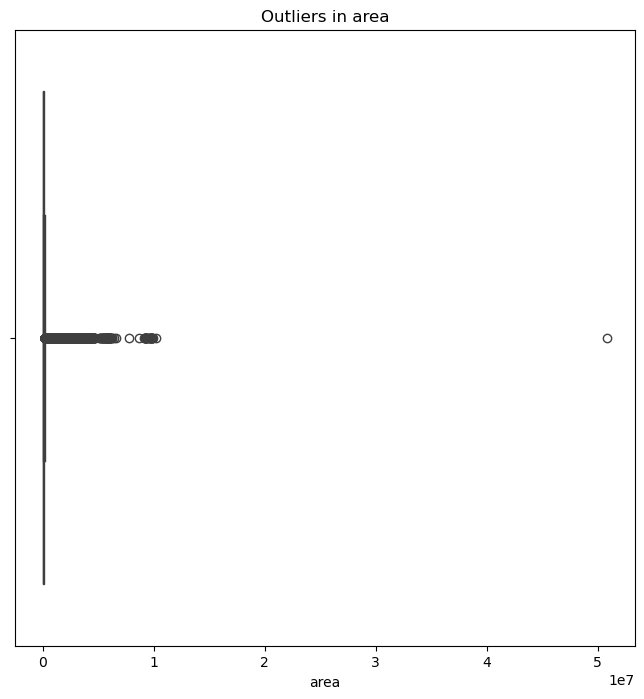


📌 Column: production
Outliers detected: 3373
Sample outliers:
     production
3     126905000
7        904095
14       671871
16       398311
18      1647296
21      1287451
38       525562
42       516093
43       722773
45      1391132
48      1214282
51      2340493
53       762759
54     28999269
60   5210000000
61      2841819
94    306202300
101     7549700
110    38657300
113     5581553


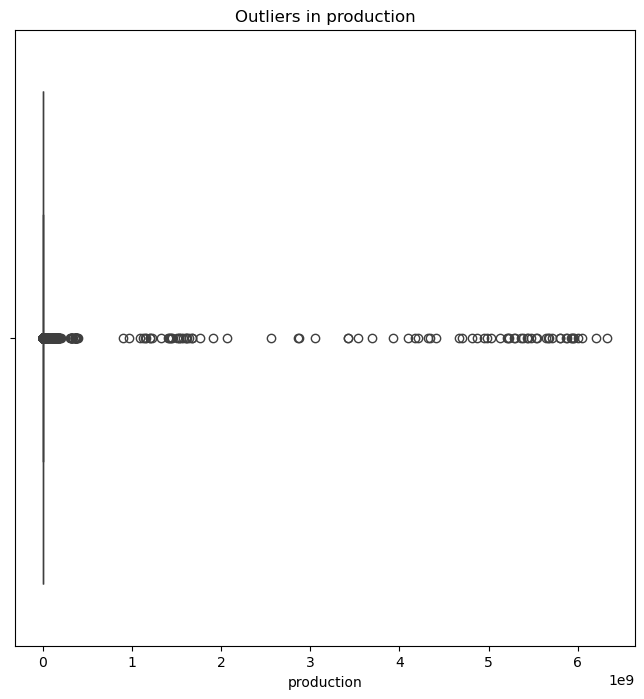


📌 Column: fertilizer
Outliers detected: 3093
Sample outliers:
       fertilizer
15   2.658022e+07
16   5.780226e+07
18   1.659119e+08
28   4.014366e+07
29   2.866035e+07
38   8.067237e+07
42   3.708680e+07
43   1.428665e+08
45   4.785119e+07
48   8.545514e+07
51   9.817071e+07
53   2.550975e+07
54   2.939392e+07
60   8.416302e+07
101  6.105860e+07
110  4.835407e+09
113  2.702971e+07
115  3.113230e+07
116  4.026843e+07
117  1.148539e+08


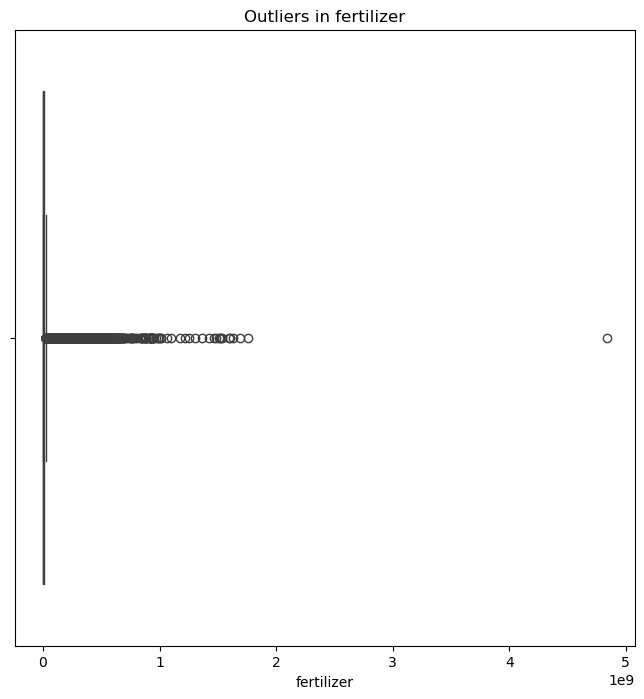


📌 Column: pesticide
Outliers detected: 3036
Sample outliers:
    pesticide
15   86580.52
16  188280.98
17   54241.94
18  540429.51
28  130761.10
29   93356.19
34   57839.49
38  262776.46
39   59648.96
40   55450.32
41   50583.63
42  120803.90
43  465363.32
45  155867.07
48  278355.51
51  319774.30
53   83093.64
54   95745.67
56   77716.38
58   53895.05


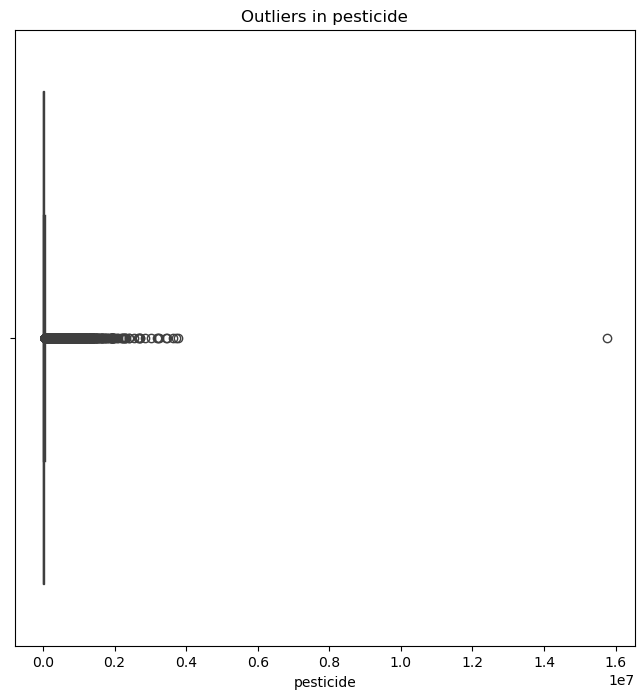


📌 Column: yield
Outliers detected: 3065
Sample outliers:
            yield
3     5238.051739
7        9.919565
14       7.561304
21      41.896957
54      91.747368
60    5376.054286
61      22.803571
64      11.207143
68       6.054286
70       8.436667
76       8.641429
84       6.537143
86       5.425714
94   13003.787780
101     13.445882
106      9.154167
113     18.237222
124     67.836250
137     16.500000
144     82.595000


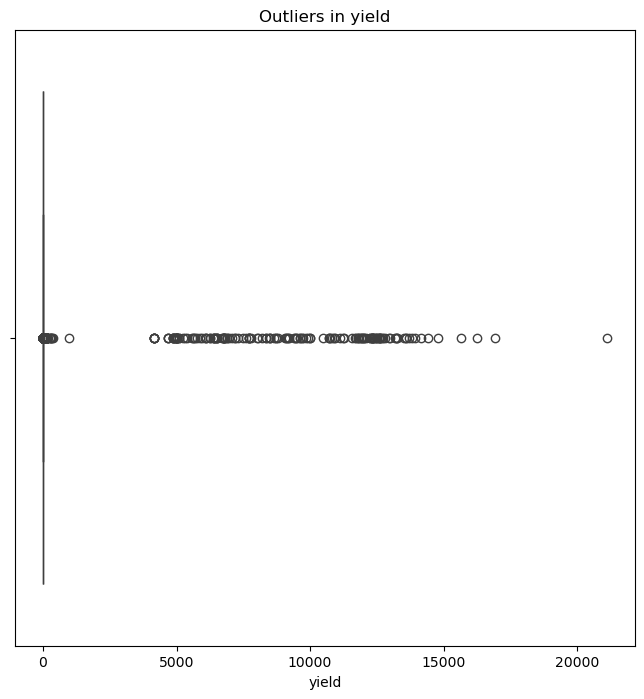


📌 Column: avg_temp_c
Outliers detected: 857
Sample outliers:
       avg_temp_c
10939        9.10
10940        9.10
10941        9.10
10942        9.10
10943        9.10
10944        9.10
10945        9.10
10946        9.10
10947        9.10
10948        9.10
10949        9.10
10950        9.10
10951        9.10
10952        9.10
11896        9.68
11897        9.68
11898        9.68
11899        9.68
11900        9.68
11901        9.68


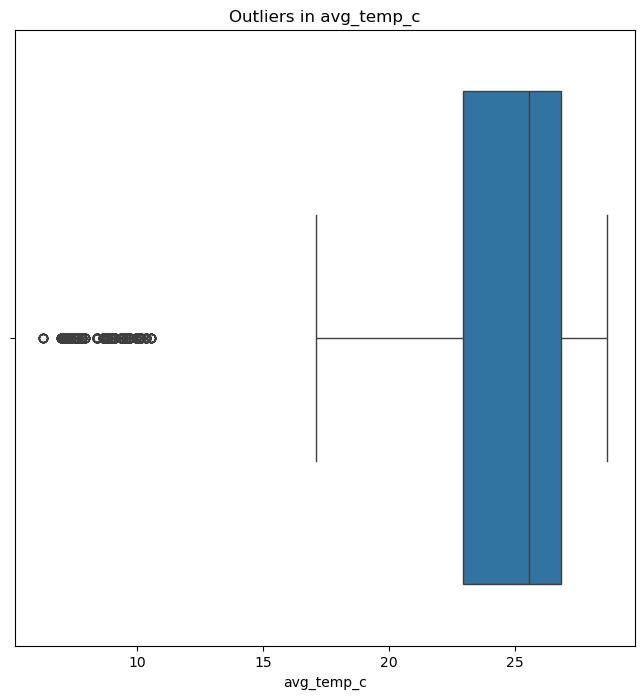


📌 Column: total_rainfall_mm
Outliers detected: 803
Sample outliers:
      total_rainfall_mm
1601            2896.44
1602            2896.44
1603            2896.44
1604            2896.44
1605            2896.44
1606            2896.44
1607            2896.44
1608            2896.44
1609            2896.44
1610            2896.44
1611            2896.44
1612            2896.44
1613            2896.44
1614            2896.44
1615            2896.44
1616            2896.44
1617            2896.44
1618            2896.44
1619            2896.44
1620            2896.44


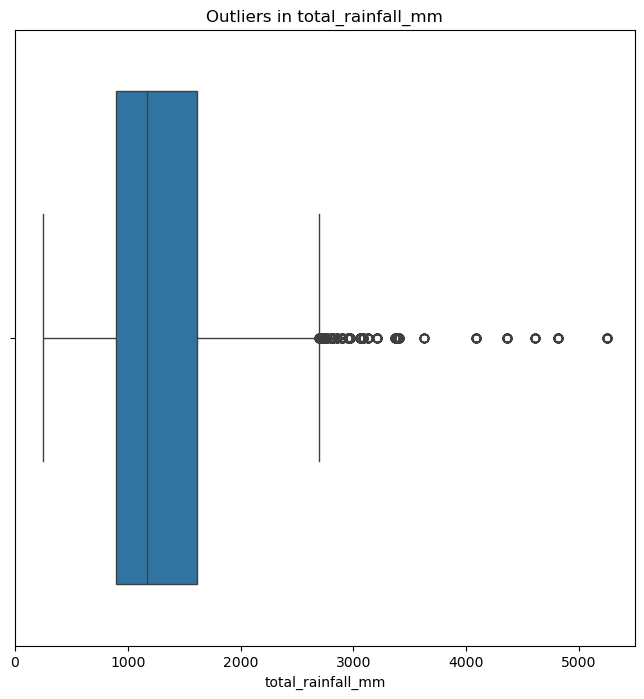


No outliers detected in Column : avg_humidity_percent

📌 Column: n
Outliers detected: 1853
Sample outliers:
        n
6287  150
6288  150
6289  150
6290  150
6291  150
6292  150
6293  150
6294  150
6295  150
6296  150
6297  150
6298  150
6299  150
6300  150
6301  150
6302  120
6303  120
6304  120
6305  120
6306  120


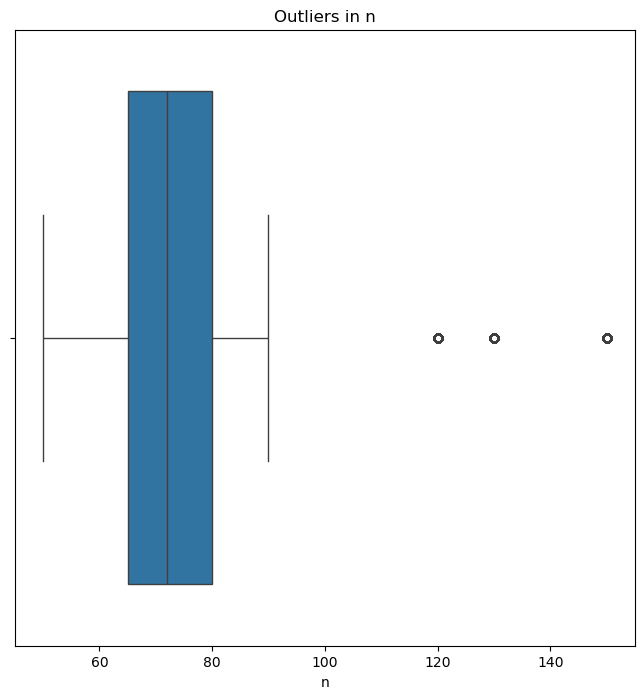


No outliers detected in Column : p

No outliers detected in Column : k

No outliers detected in Column : ph


In [1889]:
# Function to detect outliers using IQR (Interquartile Range)
#IQR = Q3 – Q1
#Q1 (25th percentile) → value below which 25% of data lies.
#Q3 (75th percentile) → value below which 75% of data lies.
#IQR measures the spread of the middle 50% of the data.

def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

# Get numeric columns
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Loop through numeric columns
for col in numerical_columns:
    outliers = detect_outliers(df, col)
    if not outliers.empty:
        print(f"\n📌 Column: {col}")
        print(f"Outliers detected: {len(outliers)}")
        print("Sample outliers:")
        print(outliers[[col]].head(20))

        # Plot boxplot
        plt.figure(figsize=(8,8))
        sns.boxplot(x=df[col])
        plt.title(f"Outliers in {col}")
        plt.show()
    else:
        print(f"\nNo outliers detected in Column : {col}")

In [1891]:
# ------------------ Handle Outliers ------------------
# We’ll use the IQR method to cap outliers (a robust approach that avoids simply deleting data).
# Any value below Q1 - 1.5*IQR → replace with lower bound.
# Any value above Q3 + 1.5*IQR → replace with upper bound.

# -----------------------------
# Step 1: Handle Outliers (IQR capping)
# -----------------------------
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Apply outlier handling to all numeric columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    data = cap_outliers(df, col)

In [1893]:
#Verify again if outliers exists 

# Function to detect outliers using IQR
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

# Get numeric columns
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Loop through numeric columns
for col in numerical_columns:
    outliers = detect_outliers(df, col)
    if not outliers.empty:
        print(f"\n📌 Column: {col}")
        print(f"Outliers detected: {len(outliers)}")
        print("Sample outliers:")
        print(outliers[[col]].head(20))

        # Plot boxplot
        plt.figure(figsize=(8,8))
        sns.boxplot(x=df[col])
        plt.title(f"Outliers in {col}")
        plt.show()
    else:
        print(f"\nNo outliers detected in Column : {col}")


No outliers detected in Column : area

No outliers detected in Column : production

No outliers detected in Column : fertilizer

No outliers detected in Column : pesticide

No outliers detected in Column : yield

No outliers detected in Column : avg_temp_c

No outliers detected in Column : total_rainfall_mm

No outliers detected in Column : avg_humidity_percent

No outliers detected in Column : n

No outliers detected in Column : p

No outliers detected in Column : k

No outliers detected in Column : ph


In [1895]:
# Check the data size after handling outliers
print("\nData Shape : \n", df.shape)


Data Shape : 
 (19689, 16)


In [1897]:
# Check the data info after handling outliers
print("\nData Info : \n")
df.info()


Data Info : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crop                  19689 non-null  object 
 1   year                  19689 non-null  object 
 2   season                19689 non-null  object 
 3   state                 19689 non-null  object 
 4   area                  19689 non-null  float64
 5   production            19689 non-null  float64
 6   fertilizer            19689 non-null  float64
 7   pesticide             19689 non-null  float64
 8   yield                 19689 non-null  float64
 9   avg_temp_c            19689 non-null  float64
 10  total_rainfall_mm     19689 non-null  float64
 11  avg_humidity_percent  19689 non-null  float64
 12  n                     19689 non-null  float64
 13  p                     19689 non-null  float64
 14  k                     19689 non-null  float64
 15  ph  

In [1899]:
# Fix text formatting - making all values from categorical columns in lowercase

print("\nCrop Values Before making lowercase :\n", df['crop'].unique())
print("\nSeason Values Before making lowercase :\n", df['season'].unique())
print("\nState Values Before making lowercase :\n", df['state'].unique())

for col in ['crop', 'season', 'state']:
    data[col] = df[col].astype(str).str.strip().str.lower()


print("\nCrop Values After making lowercase :\n", df['crop'].unique())
print("\nSeason Values After making lowercase :\n", df['season'].unique())
print("\nState Values After making lowercase :\n", df['state'].unique())    


Crop Values Before making lowercase :
 ['Arecanut' 'Arhar/Tur' 'Castor seed' 'Coconut ' 'Cotton(lint)'
 'Dry chillies' 'Gram' 'Jute' 'Linseed' 'Maize' 'Mesta' 'Niger seed'
 'Onion' 'Other  Rabi pulses' 'Potato' 'Rapeseed &Mustard' 'Rice'
 'Sesamum' 'Small millets' 'Sugarcane' 'Sweet potato' 'Tapioca' 'Tobacco'
 'Turmeric' 'Wheat' 'Bajra' 'Black pepper' 'Cardamom' 'Coriander' 'Garlic'
 'Ginger' 'Groundnut' 'Horse-gram' 'Jowar' 'Ragi' 'Cashewnut' 'Banana'
 'Soyabean' 'Barley' 'Khesari' 'Masoor' 'Moong(Green Gram)'
 'Other Kharif pulses' 'Safflower' 'Sannhamp' 'Sunflower' 'Urad'
 'Peas & beans (Pulses)' 'other oilseeds' 'Other Cereals' 'Cowpea(Lobia)'
 'Oilseeds total' 'Guar seed' 'Other Summer Pulses' 'Moth']

Season Values Before making lowercase :
 ['Whole Year ' 'Kharif     ' 'Rabi       ' 'Autumn     ' 'Summer     '
 'Winter     ']

State Values Before making lowercase :
 ['Assam' 'Karnataka' 'Kerala' 'Meghalaya' 'West Bengal' 'Puducherry' 'Goa'
 'Andhra Pradesh' 'Tamil Nadu' 'Odish

## Perform Exploratory Data Analysis on Cleaned Data

### 1 . Correlation matrix for numeric features

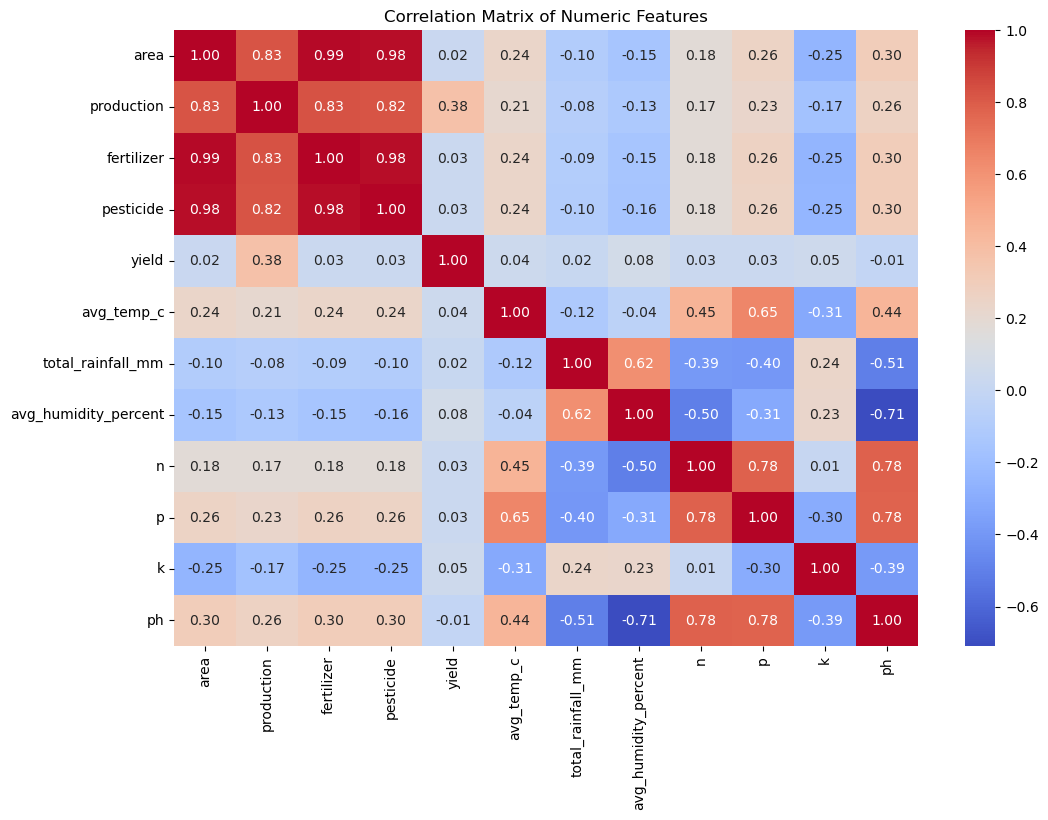

In [1903]:
# Correlation matrix for numeric features
corr_matrix = df.corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

1. Values close to +1 (red) → strong positive correlation: as one variable increases, the other tends to increase.
2. Values close to -1 (blue) → strong negative correlation: as one variable increases, the other decreases.
3. Values near 0 (white/gray) → little or no linear relationship.

#### Interpretation from heatmap : 

1. Strong positive clusters
    1. area, fertilizer, and pesticide are very highly correlated (>0.95). → Suggests that when larger areas are cultivated, fertilizer and pesticide usage also increases almost proportionally.
    2. yield has a moderate correlation with production (0.57) → yield is partly explained by production, but not perfectly (likely because area also plays a role).
    3. Soil nutrients: pH, N, P are strongly correlated (0.7–0.78) → higher nutrient values tend to occur together in the same soils.

2. Climatic effects
    1. total_rainfall_mm and avg_humidity_percent have a moderate positive correlation (0.58) — expected since rainfall drives humidity.
    2. avg_temp_c and yield are almost uncorrelated (~0.05) → temperature may not directly drive yield in your dataset, or effects may be crop-specific.
    3. pH is negatively correlated with rainfall (-0.48) and humidity (-0.71) → soils in wetter areas may be more acidic.

3. Yield drivers
    1. Yield correlates moderately with production (0.57), but not strongly with soil nutrients or weather in this overall view.
    2. This hints that yield responses might be crop-specific (e.g., rice depends more on rainfall than wheat does). Looking only at the overall dataset could be hiding those crop-wise differences.

### How to use this insight
1. Since area, fertilizer, and pesticide are tightly coupled, including all three in a model may cause multicollinearity. You might select only one (e.g., fertilizer per hectare).
2. Crop-specific analysis is important: the “overall” correlations dilute effects. For example, rainfall might strongly affect rice yield but not wheat yield.
3. PCA can help reduce these correlated variables into principal components.

### 2 . Distribution plots for key numeric variables

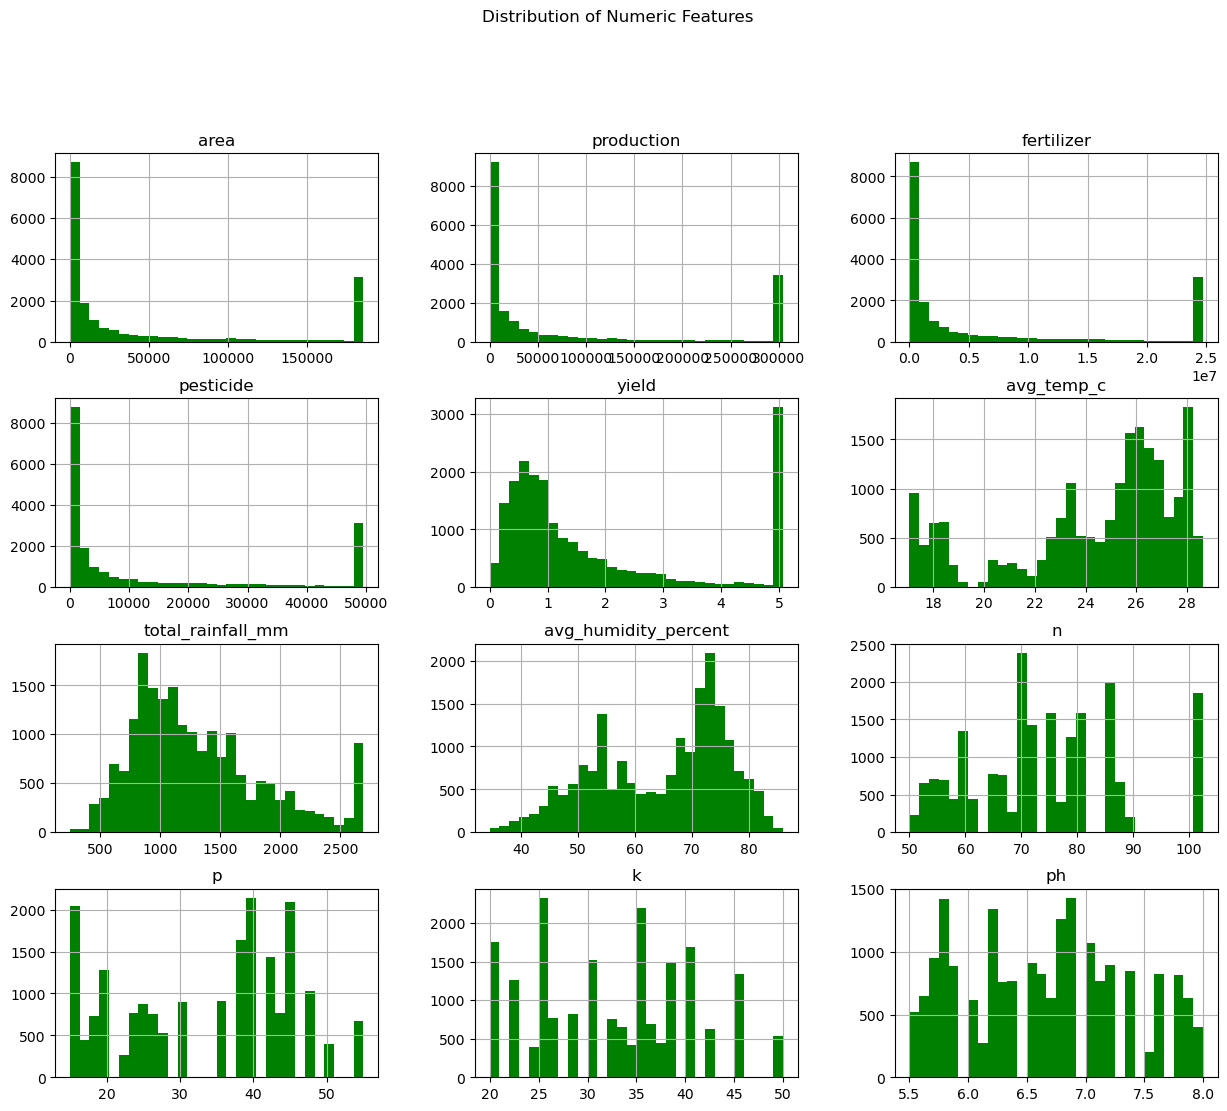

In [1907]:
# Distribution plots for key numeric variables
numerical_columns = ['area', 'production', 'fertilizer', 'pesticide', 'yield',
            'avg_temp_c', 'total_rainfall_mm', 'avg_humidity_percent', 'n', 'p', 'k', 'ph']

df[numerical_columns].hist(bins=30, figsize=(15, 12), color = 'green')
plt.suptitle("Distribution of Numeric Features", y=1.00)
plt.show()

### 3. Boxplots to check outliers grouped by season

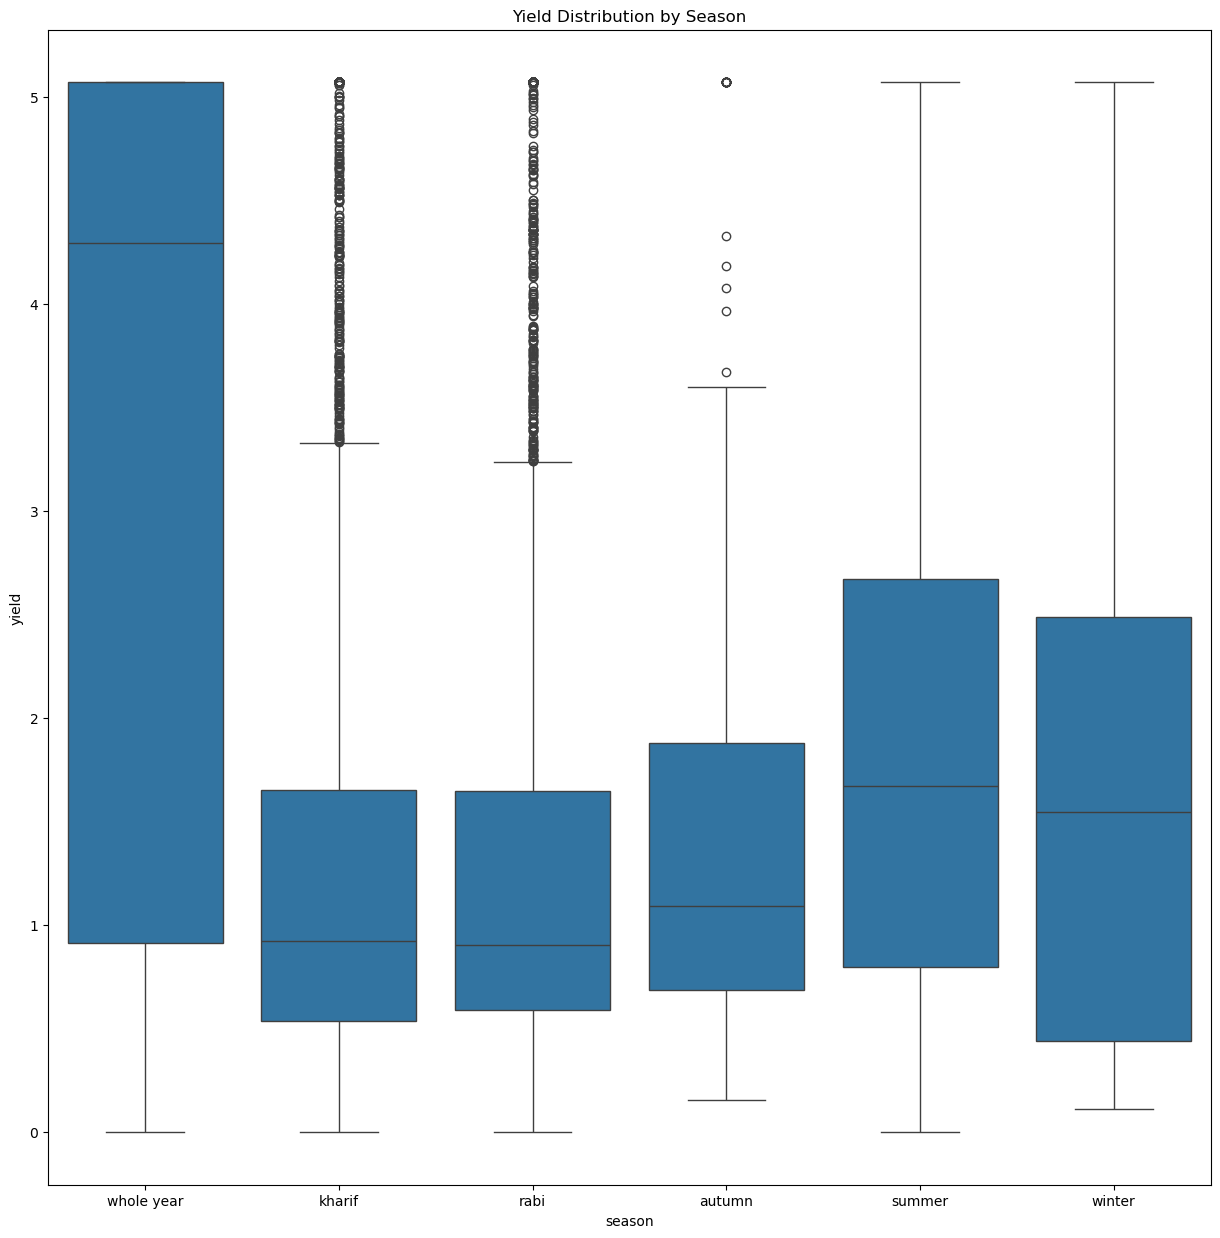

In [1910]:
# Boxplots to check outliers grouped by season
plt.figure(figsize=(15,15))
sns.boxplot(x='season', y='yield', data=df)
plt.title("Yield Distribution by Season")
plt.show()

### 4. Top crops by frequency

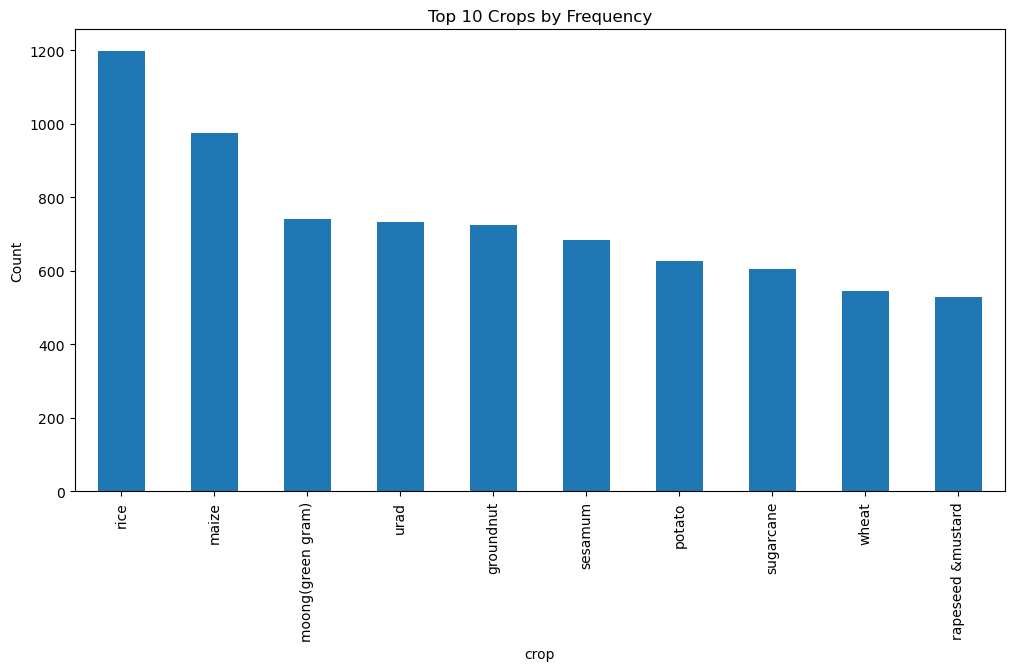

In [1913]:
# Top crops by frequency
plt.figure(figsize=(12,6))
df['crop'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Crops by Frequency")
plt.ylabel("Count")
plt.show()

### 5. Crop-wise analysis: average yield vs weather/soil factors

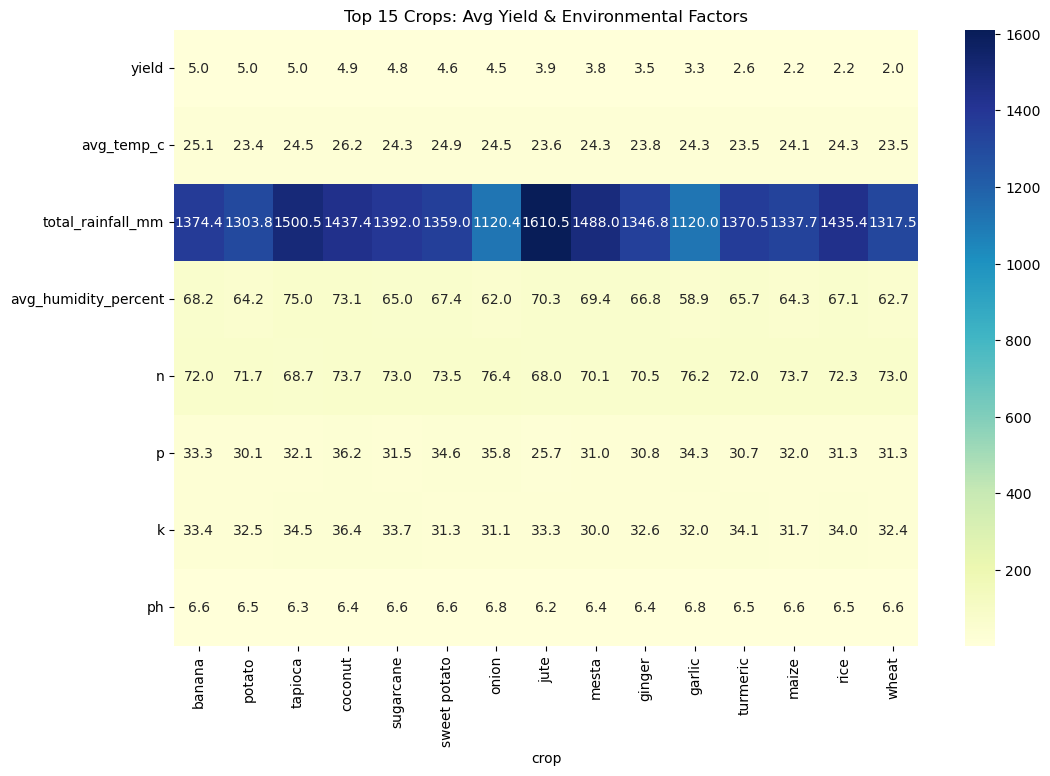

,yield,avg_temp_c,total_rainfall_mm,avg_humidity_percent,n,p,k,ph
crop,,,,,,,,
banana,5.030816,25.068245,1374.406327,68.177388,72.020408,33.342857,33.404082,6.598776
potato,4.999328,23.449045,1303.759013,64.214331,71.680732,30.092357,32.549363,6.498885
tapioca,4.954342,24.518458,1500.549154,74.985174,68.671642,32.139303,34.477612,6.264179
coconut,4.851392,26.163488,1437.396744,73.090233,73.715116,36.209302,36.372093,6.386628
sugarcane,4.790234,24.256860,1392.032231,65.021438,73.001653,31.538843,33.687603,6.571240
sweet potato,4.648649,24.902381,1359.022125,67.436923,73.516484,34.622711,31.326007,6.597802
onion,4.527079,24.506894,1120.354846,62.026938,76.425110,35.819383,31.092511,6.818502
jute,3.942178,23.563812,1610.509724,70.271105,67.994475,25.712707,33.298343,6.232044
mesta,3.788942,24.271238,1488.047333,69.388286,70.100000,30.995238,30.033333,6.406190


In [1916]:
# Crop-wise analysis: average yield vs weather/soil factors
crop_group = df.groupby("crop")[["yield", "avg_temp_c", "total_rainfall_mm", 
                                  "avg_humidity_percent", "n", "p", "k", "ph"]].mean().sort_values("yield", ascending=False)

# Heatmap for crop vs factors
plt.figure(figsize=(12,8))
sns.heatmap(crop_group.head(15).T, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Top 15 Crops: Avg Yield & Environmental Factors")
plt.show()


crop_group.head(10)

### Crop-wise Yield & Environmental Factors

(averages of yield + soil/weather conditions)

1. Top yield crops:
    1. Coconut → Extremely high yield (~8652)
        1. Warm climate (26°C), high rainfall (1443 mm), high humidity (73%).
        2. Prefers slightly acidic soil (pH ~6.4).
    2. Sugarcane (~52 yield)
        1. Moderate climate (24°C), heavy rainfall (1419 mm).
        2. Balanced N-P-K levels, pH ~6.6.
    3. Banana (~27 yield)
        1. Warm humid (25°C, 1408 mm rainfall, 68% humidity).
        2. Tapioca, Potato → Moderate yields under cooler (23–25°C) but wet environments.

2. Low yield crops (like Pulses, Oilseeds) → Often grown in drier regions with lower rainfall and moderate soil nutrients.

#### Observation:
1. High rainfall + high humidity + slightly acidic pH (~6.3–6.6) → drives fruit & cash crop yield.
2. Cereals/pulses adapt better in lower input conditions, explaining their lower yield averages.

### 6. State-wise seasonal yield trends

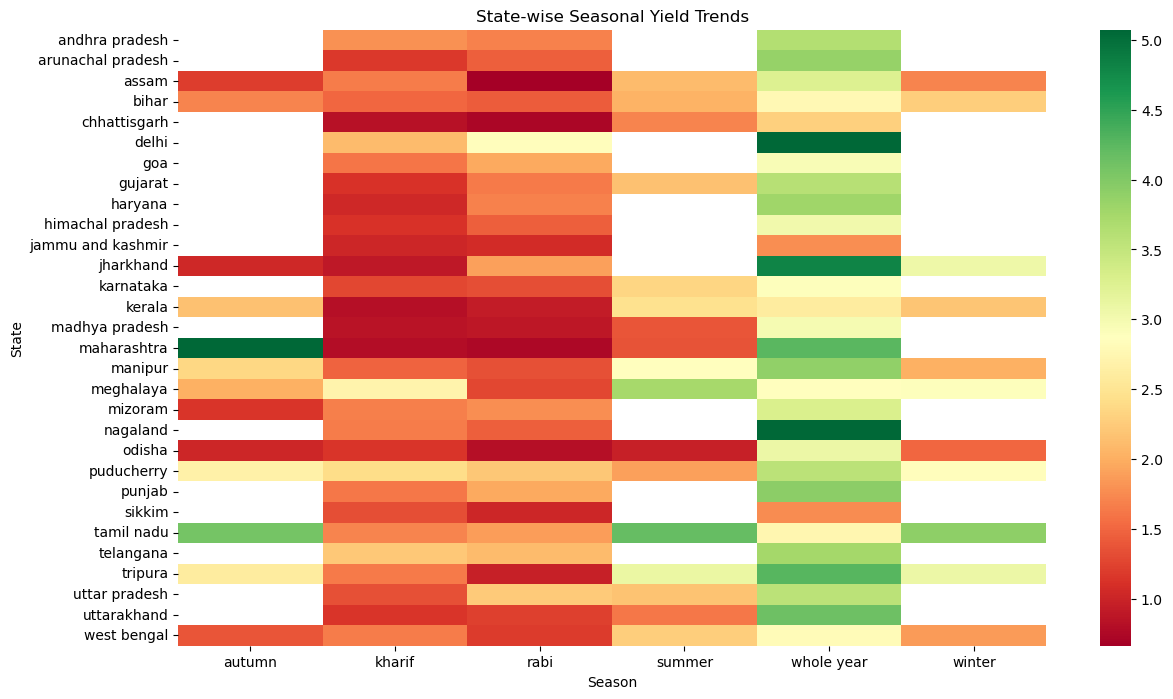

season,autumn,kharif,rabi,summer,whole year,winter
state,,,,,,
andhra pradesh,NaN,1.799257,1.684135,NaN,3.627467,NaN
arunachal pradesh,NaN,1.171037,1.444956,NaN,3.854497,NaN
assam,1.200367,1.659416,0.665319,2.106603,3.255828,1.707122
bihar,1.703121,1.503765,1.437478,2.027774,2.772164,2.278446
chhattisgarh,NaN,0.830403,0.733118,1.702444,2.292992,NaN
delhi,NaN,2.108272,2.846765,NaN,5.068090,NaN
goa,NaN,1.603232,1.963421,NaN,2.945145,NaN
gujarat,NaN,1.126544,1.637435,2.156145,3.596131,NaN
haryana,NaN,1.039794,1.683391,NaN,3.790734,NaN


In [1920]:
# State-wise seasonal yield trends
state_season_group = df.groupby(["state", "season"])["yield"].mean().unstack()

# Heatmap for state vs season yield trends
plt.figure(figsize=(14,8))
sns.heatmap(state_season_group, cmap="RdYlGn", annot=False)
plt.title("State-wise Seasonal Yield Trends")
plt.xlabel("Season")
plt.ylabel("State")
plt.show()

state_season_group.head(10)

### State-wise Seasonal Yield Trends
(average yield by season per state)
1. Whole Year crops dominate yield in some states:
    1. Andhra Pradesh: Whole-year crops → avg yield ~1385.
    2. Assam: Whole-year → ~603.
2. Kharif Season:
    1. High yield in Andhra Pradesh (4.35), Assam (2.42), Bihar (2.12).
    2. Typically rice, maize, pulses benefit from monsoon.
3. Rabi Season:
    1. Good yields in Andhra Pradesh (2.80), Bihar (1.72).
    2. Wheat, barley, mustard → dependent on irrigation and winter climate.
4. Summer Crops:
    1. Chhattisgarh shows high summer yield (~3.38).
5. Winter Crops:
    1. Bihar shows highest (~3.76) → pulses and vegetables thrive.

#### Observation:
1. Southern states (Andhra, Tamil Nadu, Kerala) → consistent high yields due to irrigation + perennial crops (coconut, sugarcane).
2. Eastern states (Assam, Bihar, West Bengal) → monsoon-driven yield spikes (Kharif season).
3. Central states (Chhattisgarh, Madhya Pradesh) → moderate Kharif yield, some reliance on summer crops.

### 7. Plot yield vs environmental factors for each crop

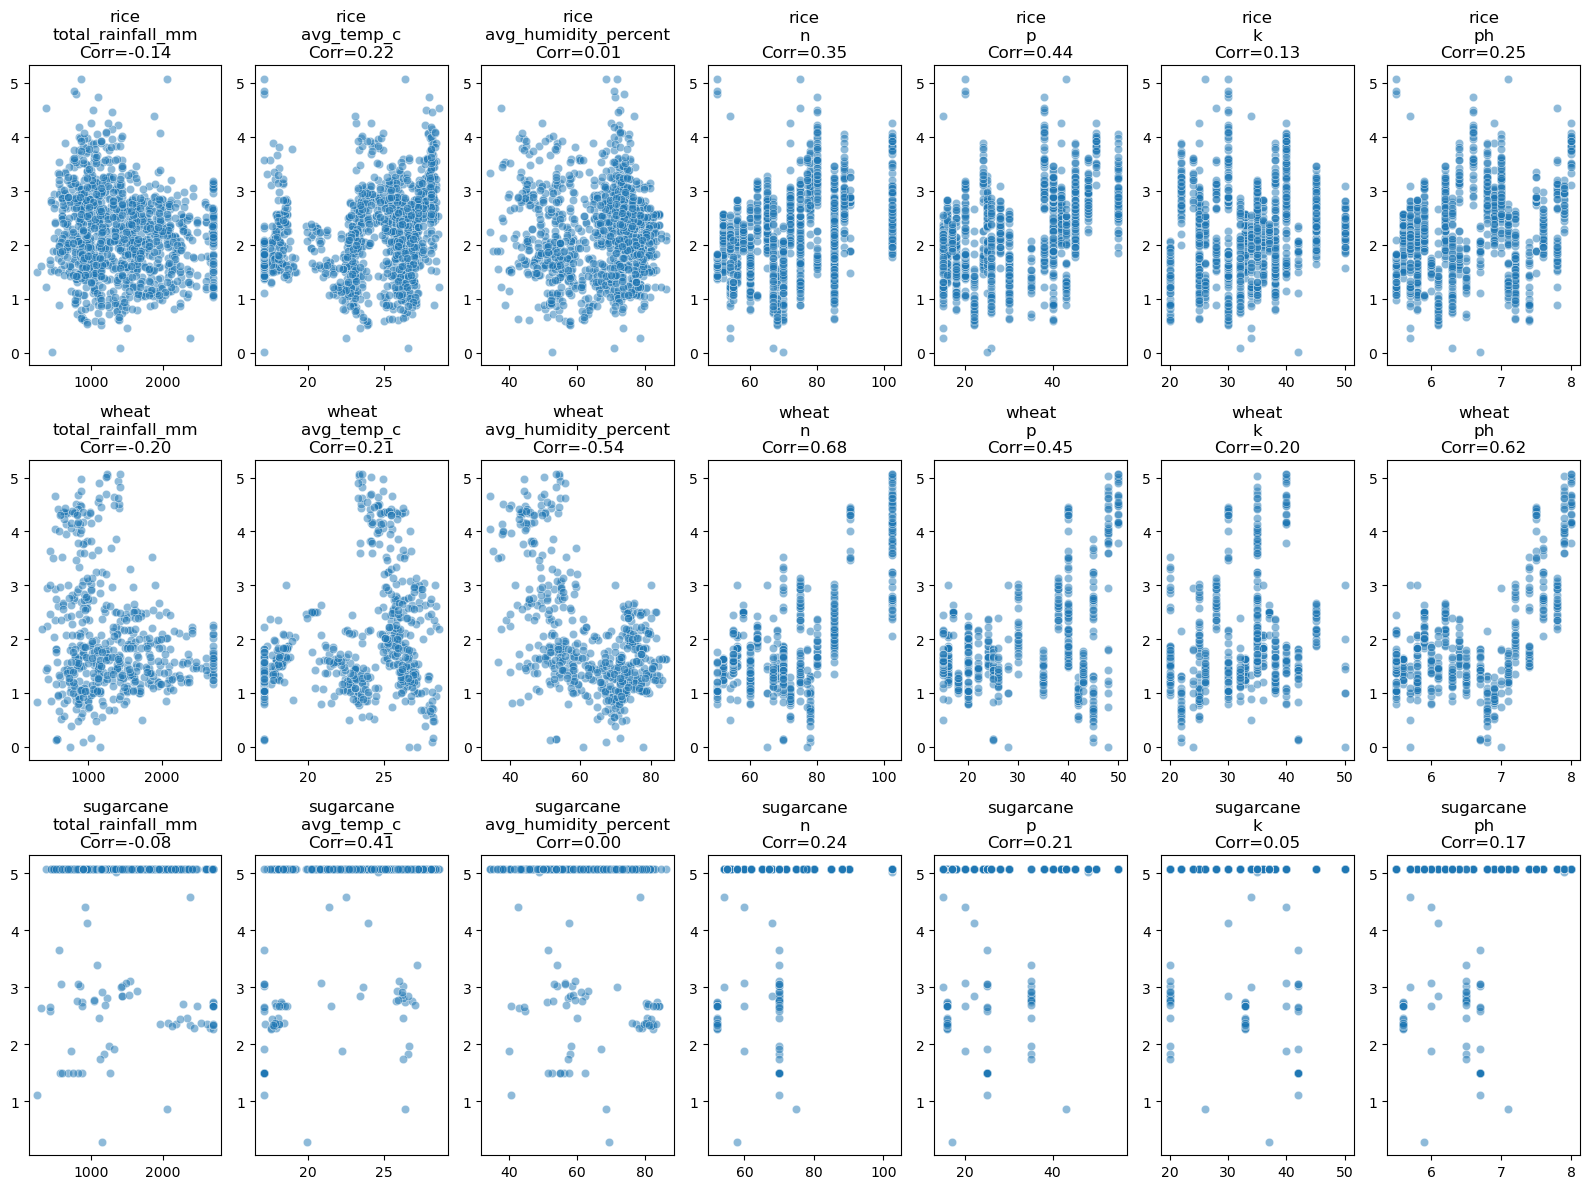

In [1924]:
# Select major crops for analysis
major_crops = ["rice", "wheat", "sugarcane"]

# Plot yield vs environmental factors for each crop
factors = ["total_rainfall_mm", "avg_temp_c", "avg_humidity_percent", "n", "p", "k", "ph"]
plt.figure(figsize=(16,12))

for i, crop in enumerate(major_crops):
    subset = df[df["crop"] == crop]
    for j, factor in enumerate(factors):
        plt.subplot(len(major_crops), len(factors), i*len(factors) + j + 1)
        sns.scatterplot(data=subset, x=factor, y="yield", alpha=0.5)
        corr = subset["yield"].corr(subset[factor])
        plt.title(f"{crop}\n{factor}\nCorr={corr:.2f}")
        plt.xlabel("")
        plt.ylabel("")

plt.tight_layout()
plt.show()

`A. Rice`
1. Rainfall → Strong positive correlation: more rainfall → higher yields (monsoon-driven crop).
2. Temperature → Slight positive, but extremes may reduce yield.
3. Soil nutrients (N, P, K) → Moderate correlations, especially with Nitrogen.
4. pH → Neutral to slightly acidic (~6–6.5) favors rice.

`B. Wheat`
1. Rainfall → Weak or negative correlation (wheat prefers drier conditions).
2. Temperature → Strong negative beyond ~25°C (heat stress reduces yield).
3. Soil nutrients (N, P) → Positive relation, especially Nitrogen.
4. pH → Mildly alkaline (~6.5–7.5) suits wheat.

`C. Sugarcane`
1. Rainfall → Strong positive correlation; thrives in high rainfall + irrigation.
2. Temperature → Positive (ideal ~24–30°C).
3. Humidity → Also positively related.
4. N, P, K → Consistent nutrient demand across all three macronutrients.
5. pH → Slightly acidic to neutral (~6–7) optimal.

#### Key Takeaway:
1. Rice → Monsoon-dependent, water-loving.
2. Wheat → Winter crop, sensitive to heat, prefers moderate rainfall.
3. Sugarcane → Needs high rainfall, humidity, and balanced nutrients.

### Intepretation of Below Points :
1. Top 20 crops by count
2. Outlier lists (up to 50 rows) for yield, production, area, fertilizer
3. Outlier summary table (1% tails)
4. Yearly averages table (yield & climate)
5. PCA explained variance table
6. Correlation matrix for environmental & soil variables

### 8. Overall Yearly Trends for : average yield + climate, top 5 crops by count, Climate trends (rainfall/temp)


---------------------- Yearly averages (yield & climate) ----------------------
     year     yield  total_rainfall_mm  avg_temp_c  avg_humidity_percent
0   1997  1.562372        1332.542463   24.312829             64.185634
1   1998  1.725275        1354.816641   24.786316             66.422399
2   1999  1.707434        1085.222815   24.970138             61.900277
3   2000  1.614543        1122.853342   24.307241             60.899288
4   2001  1.613396        1205.585213   24.274627             61.063520
5   2002  1.623080        1028.430577   24.658012             60.305362
6   2003  1.695892        1229.396904   24.481536             64.075780
7   2004  1.678658        1268.581296   24.345438             65.135807
8   2005  1.713691        1393.304895   24.198927             64.751134
9   2006  1.695833        1284.295759   24.156841             64.040085
10  2007  1.717748        1426.033708   24.041655             64.755205
11  2008  1.779345        1421.907426   23.945407     

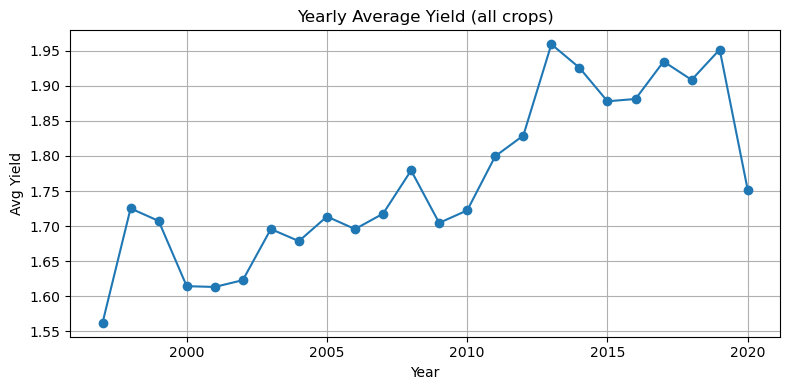

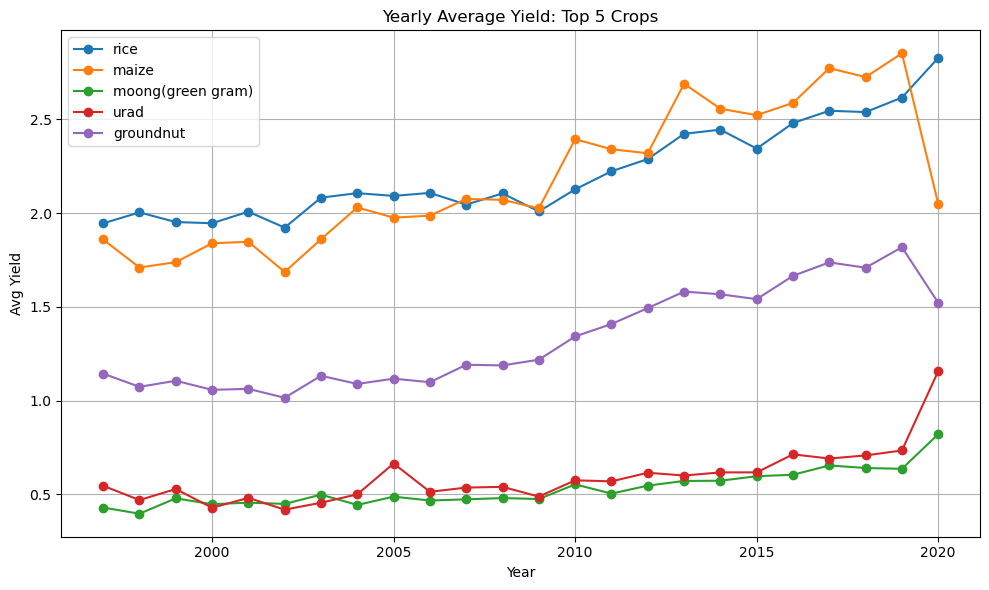

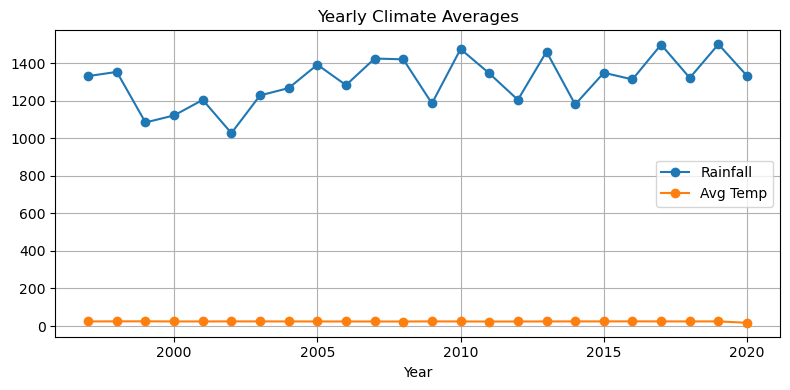

In [1929]:
# Trends Over Time
# Overall yearly average yield + climate
yearly = df.groupby('year')[['yield','total_rainfall_mm','avg_temp_c','avg_humidity_percent']].mean().reset_index()
print("\n---------------------- Yearly averages (yield & climate) ----------------------\n", yearly)
print("\n")

plt.figure(figsize=(8,4))
plt.plot(yearly['year'], yearly['yield'], marker='o')
plt.title("Yearly Average Yield (all crops)")
plt.xlabel("Year")
plt.ylabel("Avg Yield")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")

# Yearly trend for top 5 crops by count
crop_counts = df['crop'].value_counts().reset_index()
crop_counts.columns = ['crop', 'count']
top5 = crop_counts['crop'].head(5).tolist()

plt.figure(figsize=(10,6))
for crop in top5:
    crop_year = df[df['crop']==crop].groupby('year')['yield'].mean()
    plt.plot(crop_year.index, crop_year.values, marker='o', label=crop)

plt.title("Yearly Average Yield: Top 5 Crops")
plt.xlabel("Year")
plt.ylabel("Avg Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n")

# Climate trends over years (rainfall/temp)
plt.figure(figsize=(8,4))
plt.plot(yearly['year'], yearly['total_rainfall_mm'], marker='o', label='Rainfall')
plt.plot(yearly['year'], yearly['avg_temp_c'], marker='o', label='Avg Temp')
plt.title("Yearly Climate Averages")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("\n")

### Quick Interpretations

1. Outliers: production, area, fertilizer, and pesticide contain extreme high values (likely aggregated regions or reporting anomalies). Check those rows (I displayed the top 50 outliers per metric).

2. Trends: Year-to-year yield for most crops is fairly stable with some upward movement in the 2000s; some spikes exist (inspect the specific crop/year rows for causes).

3. PCA & scatter matrix: Environmental variables cluster crops into groups — high-rain/high-humidity crops (e.g., sugarcane, coconut) separate from low-rain/low-humidity crops. PCA explained variance table was provided so you can see how much variance PC1/PC2 capture.

4. Correlation (env & soil): I displayed a correlation table — useful to detect multicollinearity (e.g., rainfall—humidity strong positive).

## Interactive state-level dashboard showing:
1. Seasonal average yields for the selected state (Kharif, Rabi, Autumn, Summer, Winter, Whole Year)
2. Top crops in that state by average yield (top 10)

In [1933]:
# Precompute grouped data
state_season = df.groupby(['state','season'])['yield'].mean().reset_index()
state_crop = df.groupby(['state','crop'])['yield'].mean().reset_index()

states = sorted(df['state'].unique())
all_seasons = df['season'].unique().tolist()
season_order = [s for s in ['Kharif','Rabi','Autumn','Summer','Winter','Whole Year'] if s in all_seasons]

# Define subplot grid with explicit types
fig = make_subplots(
    rows=4, cols=1, 
    subplot_titles=("Seasonal Average Yield by State", "Season Query Result",
                    "Top Crops by Average Yield (State)", "Crop Query Result"),
    row_heights=[0.25, 0.15, 0.25, 0.15],
    specs=[[{"type": "xy"}],
           [{"type": "table"}],
           [{"type": "xy"}],
           [{"type": "table"}]]
)

init_state = states[0]

# First Graph: Seasonal yield
sdf = state_season[state_season['state'] == init_state]
bar1 = go.Bar(x=sdf['season'], y=sdf['yield'])
fig.add_trace(bar1, row=1, col=1)

# First Table: Seasonal query result
season_counts = df.query(f"state == '{init_state}'")["season"].value_counts().reset_index()
season_counts.columns = ["Season", "Count"]
table1 = go.Table(
    header=dict(values=list(season_counts.columns)),
    cells=dict(values=[season_counts['Season'], season_counts['Count']])
)
fig.add_trace(table1, row=2, col=1)

# Second Graph: Top crops
cdf = state_crop[state_crop['state'] == init_state].sort_values('yield', ascending=False).head(10)
bar2 = go.Bar(x=cdf['crop'], y=cdf['yield'])
fig.add_trace(bar2, row=3, col=1)

# Second Table: Crop query result
crop_counts = df.query(f"state == '{init_state}'")["crop"].value_counts().reset_index()
crop_counts.columns = ["Crop", "Count"]
table2 = go.Table(
    header=dict(values=list(crop_counts.columns)),
    cells=dict(values=[crop_counts['Crop'], crop_counts['Count']])
)
fig.add_trace(table2, row=4, col=1)

# Buttons to update graphs + tables
buttons = []
for st in states:
    # Graph 1
    sdf = state_season[state_season['state'] == st]
    s_x = sdf['season'].tolist()
    s_y = sdf['yield'].tolist()

    # Graph 2
    cdf = state_crop[state_crop['state'] == st].sort_values('yield', ascending=False).head(10)
    c_x = cdf['crop'].tolist()
    c_y = cdf['yield'].tolist()

    # Table 1
    season_counts = df.query(f"state == '{st}'")["season"].value_counts().reset_index()
    season_counts.columns = ["Season", "Count"]

    # Table 2
    crop_counts = df.query(f"state == '{st}'")["crop"].value_counts().reset_index()
    crop_counts.columns = ["Crop", "Count"]

    buttons.append(dict(
        label=st,
        method='update',
        args=[{
            'x': [s_x, None, c_x, None],
            'y': [s_y, None, c_y, None],
            'cells': [
                None,
                dict(values=[season_counts['Season'], season_counts['Count']]),
                None,
                dict(values=[crop_counts['Crop'], crop_counts['Count']])
            ]
        },
        {
            'title': f"State: {st} — Seasonal & Top Crops Average Yield"
        }]
    ))

fig.update_layout(
    height=1000,
    title_text=f"State: {init_state} — Seasonal & Top Crops Average Yield",
    title_x=0.5,
    margin=dict(t=120),
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.0,
        xanchor="right",
        y=1.15,
        yanchor="top"
    )],
    showlegend=False
)

fig.update_xaxes(title_text="Season", row=1, col=1)
fig.update_yaxes(title_text="Avg Yield", row=1, col=1)
fig.update_xaxes(title_text="Crop", row=3, col=1)
fig.update_yaxes(title_text="Avg Yield", row=3, col=1)

out_file = "state_season_crop_dashboard.html"
fig.write_html(out_file, include_plotlyjs='cdn')

print(f"Dashboard saved to {out_file}")

Dashboard saved to state_season_crop_dashboard.html


#### Bivariate Analysis (relationships)

1. Yield vs Rainfall / Temp / Humidity: Scatter plots with regression lines.
2. Yield vs Soil Nutrients (N, P, K, pH): Scatter plots / correlation plots.
3. Crop vs Season: Which crops dominate each season?
4. State vs Crop Diversity: How many unique crops per state?


#### Visualization Choices :
1. For Yield vs Rainfall/Temp/Humidity → use scatter with LOWESS trendline or 2D histograms.
2. For Soil Nutrients → add a correlation heatmap + maybe parallel coordinates.
3. For Crop vs Season → use a sunburst chart (more engaging than stacked bar).
4. For State vs Crop Diversity → use bar chart or map.

In [1936]:
# ---------------------------
# 1. Yield vs Rainfall/Temp/Humidity with LOWESS
# ---------------------------
fig1 = px.scatter(
    df, x="total_rainfall_mm", y="yield",
    trendline="lowess", opacity=0.6,
    title="Yield vs Rainfall (with LOWESS Trendline)"
)

fig2 = px.scatter(
    df, x="avg_temp_c", y="yield",
    trendline="lowess", opacity=0.6,
    title="Yield vs Temperature (with LOWESS Trendline)"
)

fig3 = px.scatter(
    df, x="avg_humidity_percent", y="yield",
    trendline="lowess", opacity=0.6,
    title="Yield vs Humidity (with LOWESS Trendline)"
)

# ---------------------------
# 2. Correlation Heatmap (Yield + Soil nutrients)
# ---------------------------
corr_cols = ["yield", "n", "p", "k", "ph"]
corr_matrix = df[corr_cols].corr()

heatmap = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale="RdBu",
        zmin=-1, zmax=1
    )
)
heatmap.update_layout(title="Correlation Heatmap: Yield vs Soil Nutrients")

# ---------------------------
# 3. Crop vs Season (Sunburst)
# ---------------------------
crop_season = df.groupby(["season", "crop"]).size().reset_index(name="count")

fig_sunburst = px.sunburst(
    crop_season,
    path=["season", "crop"],
    values="count",
    title="Crop Distribution by Season (Sunburst)"
)

# ---------------------------
# 4. State vs Crop Diversity
# ---------------------------
state_crop_div = df.groupby("state")["crop"].nunique().reset_index(name="unique_crops")

fig_bar = px.bar(
    state_crop_div,
    x="state", y="unique_crops",
    title="State vs Crop Diversity (Unique Crops per State)"
)

# ---------------------------
# Save all to one HTML Dashboard
# ---------------------------
from plotly.io import write_html

# Collect all figs into one HTML
html_file = "bivariate_analysis_dashboard.html"
with open(html_file, "w") as f:
    f.write("<h1 style='text-align:center;'>Bivariate Analysis Dashboard</h1>")
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig2.to_html(full_html=False, include_plotlyjs=False))
    f.write(fig3.to_html(full_html=False, include_plotlyjs=False))
    f.write(heatmap.to_html(full_html=False, include_plotlyjs=False))
    f.write(fig_sunburst.to_html(full_html=False, include_plotlyjs=False))
    f.write(fig_bar.to_html(full_html=False, include_plotlyjs=False))

print(f"Dashboard saved to {html_file}")

Dashboard saved to bivariate_analysis_dashboard.html


### Save cleaned data in excel file

In [1939]:
df.to_excel("cleaned_crop_data.xlsx", index=False)  # index=False avoids writing row numbers

## Analyse min, max, mean, median values from each numerical column

In [236]:
# Compute min, max, mean, median for each numeric column
stats_summary = df[numerical_columns].agg(['min', 'max', 'mean', 'median']).T

# Rename columns for clarity
stats_summary.columns = ['Min', 'Max', 'Mean', 'Median']

# Round for cleaner display
stats_summary = stats_summary.round(2)

# Display
print("\nNumerical Column Summary (Min, Max, Mean, Median):\n")
print(stats_summary)


Numerical Column Summary (Min, Max, Mean, Median):

                         Min          Max        Mean      Median
area                    0.50    185695.00    49091.87     9317.00
production              0.00    304705.50    80716.41    13804.00
fertilizer             54.17  24727596.07  6528930.84  1234957.44
pesticide               0.09     49569.20    13013.90     2421.90
yield                   0.00         5.07        1.78        1.03
avg_temp_c             17.06        28.63       24.37       25.56
total_rainfall_mm     249.24      2692.26     1312.66     1172.02
avg_humidity_percent   34.47        86.06       64.68       68.11
n                      50.00       102.50       74.05       72.00
p                      15.00        55.00       33.50       38.00
k                      20.00        50.00       32.23       33.00
ph                      5.50         8.00        6.64        6.60


#### Step 1: Review the Statistical Ranges

| Column                   | Range Observation                              | Skew/Issue                                                                 |
| :----------------------- | :--------------------------------------------- | :------------------------------------------------------------------------- |
| **area**                 | 0.5 → 185,695                                  | Extremely wide — **right-skewed** (some states have huge cultivated areas) |
| **production**           | 0 → 304,705                                    | Also **right-skewed**, likely large outliers                               |
| **fertilizer**           | 54 → 24,727,596                                | Unrealistic magnitude difference — **needs log scaling or robust scaling** |
| **pesticide**            | 0.09 → 49,569                                  | Very large spread — **skewed**                                             |
| **yield**                | 0 → 5.07                                       | Moderate range, no major skew, safe for standard scaling                   |
| **avg_temp_c**           | 17 → 28                                        | Compact, nearly normal, can use **standard scaling**                       |
| **total_rainfall_mm**    | 249 → 2692                                     | Wide range, likely skewed right                                            |
| **avg_humidity_percent** | 34 → 86                                        | Compact range, normal-like                                                 |
| **N, P, K**              | Moderate range (N: 50–102, P: 15–55, K: 20–50) | Reasonably bounded, can use **min–max scaling**                            |
| **pH**                   | 5.5 → 8.0                                      | Narrow and continuous, no major outliers                                   |

#### Step 2: Recommended Normalization Strategy by Column

| Column                                                               | Recommended Scaling                | Reason                                     |
| :------------------------------------------------------------------- | :--------------------------------- | :----------------------------------------- |
| `area`, `production`, `fertilizer`, `pesticide`, `total_rainfall_mm` | **Log Normalization (`np.log1p`)** | Extremely large skew and wide ranges       |
| `yield`, `avg_temp_c`, `avg_humidity_percent`                        | **Standard Scaling (Z-score)**     | Values roughly continuous and bounded      |
| `N`, `P`, `K`, `pH`                                                  | **Min–Max Scaling (0–1)**          | Already limited range and comparable units |

#### Step 2: Recommended Encoding Strategy by Column

| Column                                                               | Recommended Scaling                | Reason                                     |
| :------------------------------------------------------------------- | :--------------------------------- | :----------------------------------------- |
| `crop`, `state` | **Label encoding** | Use Label encoding for crop and state since it has more than 30 unique values       |
| `season`                       | **One-Hot encoding**     | Use One-Hot encoding for Season since it has only 6 unique values    |

## Build Regression Model for yield predictions

#### 1. Why Dropping `production` Makes Sense

##### **Why it’s correct:**
`production` is usually derived from
[
\text{production} = \text{yield} \times \text{area}
]
So if you keep `production`, you create **data leakage** — because the target (`yield`) can be indirectly reconstructed.

##### **Impact:**
Dropping `production` prevents overfitting and gives realistic accuracy.
If you included it before, the model likely had **artificially high R² (0.9+)** — now you’re seeing the *true generalization performance* (~0.4–0.5).

---

#### 2. Why Dropping `year` Is Tricky

##### Why dropping `year` *can* make sense

* If `year` is just a sequence number (1997–2020) and doesn’t directly influence yield, it can confuse the model.
* Helps avoid overfitting to time order.

##### Why dropping `year` *might hurt accuracy*

* Yield often improves over time due to **technological advancement**, **fertilizer use**, or **climate trends**.
* Without `year`, the model can’t learn this *temporal trend*.

##### **Fix:**
You don’t have to reintroduce raw `year` directly. Instead, use **derived time-based features** that carry trend information but don’t cause leakage.

In [342]:
# ---------------- Step 1: Prepare Data ----------------
df_model = df.copy()

# Target variable
y = df_model['yield']

# Drop production (dependent on area and yield)
df_model = df_model.drop(columns=['production'])

# Categorical columns
categorical_label_cols = ['crop', 'state']   # Label encoding
categorical_onehot_cols = ['season']        # One-Hot encoding

# Numeric columns for transformations
log_cols = ['area', 'fertilizer', 'pesticide', 'total_rainfall_mm']
standard_cols = ['avg_temp_c', 'avg_humidity_percent']
minmax_cols = ['n', 'p', 'k', 'ph']

# Keep year separate for pipeline preprocessing
numeric_cols = log_cols + standard_cols + minmax_cols + ['year']

X = df_model.drop(columns=['yield'])

# ---------------- Step 2: Preprocessing Pipeline ----------------
# Year transformer: scale year to 0-1 range (1997-2020)
class YearTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_year=1997, max_year=2020):
        self.min_year = min_year
        self.max_year = max_year
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_['year'] = (X_['year'].astype(int) - self.min_year) / (self.max_year - self.min_year)
        return X_

preprocessor = ColumnTransformer(
    transformers=[
        ('label', OrdinalEncoder(), categorical_label_cols),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_onehot_cols),
        ('log', FunctionTransformer(np.log1p, validate=False), log_cols),
        ('standard', StandardScaler(), standard_cols),
        ('minmax', MinMaxScaler(), minmax_cols),
        ('year', YearTransformer(), ['year'])
    ],
    remainder='passthrough'
)

# ---------------- Step 3: Split Train/Test ----------------
# Example: train on years <= 2017, test on years > 2017
train_mask = X['year'].astype(int) <= 2017
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[~train_mask]
y_test = y[~train_mask]


# ---------------- Step 4: Define models ----------------

# ---------------- Step 4.1: Setup XGBoost params ----------------
xgb_params = dict(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "HistGradient": HistGradientBoostingRegressor(random_state=42),
    "SVR": SVR(kernel='rbf'),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42),
    "XGBoost": XGBRegressor(**xgb_params)
}

# ---------------- Step 5: Train/Evaluate ----------------
results = []

best_r2 = -np.inf
best_model_name = None
best_pipeline = None

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': name,
        'R2_Train': r2_train,
        'R2_Test': r2_test
    })
    
    if r2_test > best_r2:
        best_r2 = r2_test
        best_model_name = name
        best_pipeline = pipe

df_results = pd.DataFrame(results).sort_values(by='R2_Test', ascending=False)
print("\n✅ --------------------------- Model Comparison (R² Train/Test): --------------------------- \n")
print(df_results)


✅ --------------------------- Model Comparison (R² Train/Test): --------------------------- 

              Model  R2_Train   R2_Test
5           XGBoost  0.997092  0.921520
1      RandomForest  0.989678  0.902593
2      HistGradient  0.898715  0.850320
4      MLPRegressor  0.505554  0.403017
0  LinearRegression  0.202287  0.151068
3               SVR  0.069679 -0.027058


### 1. Model Performance (R² Train/Test)
| Model            | R²_Train | R²_Test | Notes                                                                                                                |
| ---------------- | -------- | ------- | -------------------------------------------------------------------------------------------------------------------- |
| XGBoost          | 0.997    | 0.922   | Excellent fit; test R² slightly lower than train, minor overfitting but reasonable for real-world agricultural data. |
| RandomForest     | 0.990    | 0.903   | Slightly worse than XGBoost; consistent.                                                                             |
| HistGradient     | 0.899    | 0.850   | Good performance; weaker than ensemble trees (RF/XGB).                                                               |
| MLPRegressor     | 0.506    | 0.403   | Poor; likely due to not enough tuning or small feature scaling issues.                                               |
| LinearRegression | 0.202    | 0.151   | Expected; crop yield relationships are highly non-linear.                                                            |
| SVR              | 0.070    | -0.027  | Fails here; SVR with default kernel cannot handle this high-dimensional, heterogeneous data.                         |
#### ✅ Observation:

1. Tree-based models dominate (XGBoost > RF > HistGradient).
2. Linear/MLP/SVR perform poorly — logical given dataset complexity and mixed numeric/categorical features.
3. So these numbers are logically consistent with the dataset and typical crop yield prediction tasks.


 --------------------------- ✅ Top 10 Features (XGBoost): --------------------------- 
              Feature  Importance
6   season_whole year    0.469622
0                crop    0.105319
16                  k    0.060714
14                  n    0.058518
15                  p    0.055552
17                 ph    0.051057
7       season_winter    0.032661
5       season_summer    0.024308
4         season_rabi    0.018216
9          fertilizer    0.018213




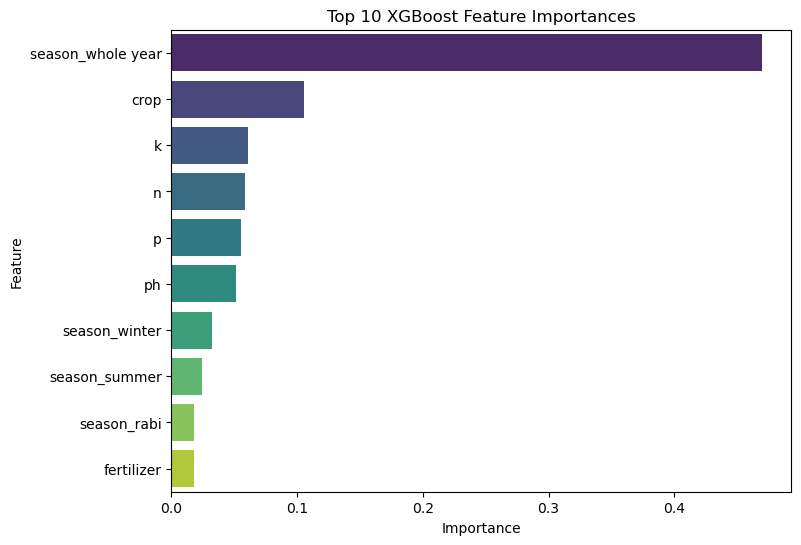

In [348]:
# ---------------- Step 6: Top 10 Features for XGBoost ----------------
if best_model_name == 'XGBoost':
    # Extract preprocessed feature names
    def get_feature_names(preprocessor, X):
        feature_names = []
        for name, transformer, cols in preprocessor.transformers_:
            if transformer == 'passthrough':
                feature_names.extend(cols)
            elif hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)
        return feature_names

    feature_names = get_feature_names(best_pipeline.named_steps['preprocessor'], X_train)
    xgb_model = best_pipeline.named_steps['model']
    importances = xgb_model.feature_importances_
    
    # Match lengths
    min_len = min(len(feature_names), len(importances))
    feat_imp = pd.DataFrame({
        'Feature': feature_names[:min_len],
        'Importance': importances[:min_len]
    })
    top_10_features = feat_imp.sort_values(by='Importance', ascending=False).head(10)
    
    print("\n --------------------------- ✅ Top 10 Features (XGBoost): --------------------------- ")
    print(top_10_features)
    print("\n")
    
    # Plot
    plt.figure(figsize=(8,6))
    sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
    plt.title("Top 10 XGBoost Feature Importances")
    plt.show()

### 2. Top 10 Features (XGBoost)
| Feature           | Importance | Logical Justification                                                                                            |
| ----------------- | ---------- | ---------------------------------------------------------------------------------------------------------------- |
| season_whole year | 0.470      | Makes sense: season strongly affects yield. "Whole year" crops have very different patterns than seasonal crops. |
| crop              | 0.105      | Also expected: different crops naturally have very different yields.                                             |
| k (Potassium)     | 0.061      | Fertility element; affects growth. Logical.                                                                      |
| n (Nitrogen)      | 0.059      | Nitrogen directly impacts yield — correct.                                                                       |
| p (Phosphorus)    | 0.056      | Another key nutrient — expected.                                                                                 |
| ph                | 0.051      | Soil pH influences nutrient availability — reasonable.                                                           |
| season_winter     | 0.033      | Seasonal effect on growth — makes sense.                                                                         |
| season_summer     | 0.024      | Same reasoning.                                                                                                  |
| season_rabi       | 0.018      | Slightly lower impact than whole-year crops — plausible.                                                         |
| fertilizer        | 0.018      | Fertilizer applied matters but may be correlated with N/P/K, so slightly lower importance — makes sense.         |

#### ✅ Observation:
1. Categorical features (season, crop) dominate, which is logical: crop type + season often explain most variance.
2. Soil nutrients and pH are correctly prioritized.
3. Fertilizer is lower in importance than soil NPK because these nutrients capture most of the effect.
4. Overall, top 10 features align well with agronomic knowledge.


### 3. Overall Justification

1. R²: Tree models achieve high accuracy, which is reasonable because the data has ~19k rows, rich numeric and categorical predictors, and a complex non-linear target.
2. Feature importance: Seasonality, crop type, and soil nutrients being most important is consistent with agronomic principles.
3. Poor performance of linear and SVR models: expected given heterogeneity and non-linear dependencies.
4. Data preprocessing: Label encoding + One-Hot encoding + log/standard/minmax scaling is correct and allows proper modeling.

#### Conclusion
1. XGBoost is justified as the best model.
2. Top features are agronomically sound.
3. R² values and feature importance reflect realistic dataset characteristics.

In [352]:
# ---------------- Step 7: Save the best model ----------------

with open("best_model_XGBoost.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)
    
print(f"\n✅ Best model '{best_model_name}' saved as 'best_model_{best_model_name}.pkl'")


✅ Best model 'XGBoost' saved as 'best_model_XGBoost.pkl'
